In [282]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras as k
print(k.__version__)
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_contrib.layers import CRF

3.6.0


In [283]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {k.__version__}")

TensorFlow version: 2.17.0
Keras version: 3.6.0


In [ ]:
import pandas as pd

dframe = pd.read_csv('dataset_idx_Rexi.csv',encoding='latin1', sep=';')
dframe['SentenceIDX'] = dframe['SentenceIDX'].fillna(0).astype(int)
dframe.dropna(inplace=True)
dframe

dataset = dframe
dataset.info()

from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

texts = dataset["Token"].astype(str).values  # Convert the column to string type

# Inisialisasi tokenizer
tokenizer = Tokenizer()

tokenizer.fit_on_texts(texts)

# Dapatkan vocab size
vocab_size = len(tokenizer.word_index) + 1  # Tambahkan 1 untuk token padding

print(f"Vocabulary Size: {vocab_size}")

<class 'pandas.core.frame.DataFrame'>
Index: 4800 entries, 0 to 4993
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Token        4800 non-null   object
 1   BIOLabel     4800 non-null   object
 2   SentenceIDX  4800 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 131.2+ KB
Vocabulary Size: 1039


In [285]:
class SentenceGetter(object):

    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Token"].values.tolist(),
                                                        s["BIOLabel"].values.tolist())]
        self.grouped = self.dataset.groupby("SentenceIDX").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [286]:
getter = SentenceGetter(dataset)
sentences = getter.sentences
print(sentences[19])

[('HUAWEI', 'B-Brand'), ('HP', 'B-Product'), ('40', 'I-Product'), ('Pro', 'I-Product'), ('8/256GB', 'B-Specifications'), ('-', 'O'), ('Helio', 'B-Specifications'), ('G99', 'I-Specifications'), ('-', 'O'), ('6.78', 'B-Specifications'), ('FHD+', 'I-Specifications'), ('-', 'O'), ('108MP', 'B-Specifications'), ('AI', 'I-Specifications'), ('Dual', 'I-Specifications'), ('Camera', 'I-Specifications'), ('-', 'O'), ('5000', 'B-Specifications'), ('mAh', 'I-Specifications'), ('-', 'O'), ('NFC', 'B-Specifications'), ('dengan', 'O'), ('potongan', 'B-Promo'), ('6%!', 'I-Promo'), ('Hanya', 'O'), ('Rp2.059.000.', 'B-Price'), ('Dapatkan', 'O'), ('segera', 'O'), ('di', 'O'), ('Shopee', 'B-OnlineShop'), ('#ShopeeID', 'O')]


In [287]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 42


In [288]:
words = list(set(dataset["Token"].values))
words.append("ENDPAD")
words[102]

'Rp3.223.500.'

In [289]:
n_words = len(words); n_words

1229

In [290]:
tags = []
for tag in set(dataset["BIOLabel"].values):
    if tag is np.nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)

['I-Specifications', 'B-Promo', 'O', 'B-OnlineShop', 'I-Brand', 'I-Warranty', 'I-Promo', 'I-Product', 'B-Price', 'B-Specifications', 'B-Product', 'B-Warranty', 'B-Brand']


In [291]:
n_tags = len(tags); n_tags

13

In [292]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [293]:
word2idx['HP']

803

In [294]:
tag2idx


{'I-Specifications': 0,
 'B-Promo': 1,
 'O': 2,
 'B-OnlineShop': 3,
 'I-Brand': 4,
 'I-Warranty': 5,
 'I-Promo': 6,
 'I-Product': 7,
 'B-Price': 8,
 'B-Specifications': 9,
 'B-Product': 10,
 'B-Warranty': 11,
 'B-Brand': 12}

In [295]:
idx2tag

{0: 'I-Specifications',
 1: 'B-Promo',
 2: 'O',
 3: 'B-OnlineShop',
 4: 'I-Brand',
 5: 'I-Warranty',
 6: 'I-Promo',
 7: 'I-Product',
 8: 'B-Price',
 9: 'B-Specifications',
 10: 'B-Product',
 11: 'B-Warranty',
 12: 'B-Brand'}

In [296]:
sentences[68]

[('Temukan', 'O'),
 ('HUAWEI', 'B-Brand'),
 ('-', 'O'),
 ('Defect', 'O'),
 ('Sale', 'O'),
 ('HP', 'B-Product'),
 ('LOW', 'O'),
 ('PRICE', 'O'),
 ('ALL', 'O'),
 ('BLACK', 'O'),
 ('|', 'O'),
 ('|', 'O'),
 ('|', 'O'),
 ('di', 'O'),
 ('Blibli', 'B-OnlineShop'),
 ('lagi', 'O'),
 ('diskon', 'B-Promo'),
 ('80%', 'I-Promo'),
 ('harganya', 'O'),
 ('jadi', 'O'),
 ('Rp2.556.500!', 'B-Price')]

In [297]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
#X = pad_sequences(X)
# np.array(X).shape

In [298]:
X[1]

[959,
 315,
 846,
 408,
 1003,
 112,
 126,
 1183,
 458,
 724,
 525,
 785,
 222,
 778,
 705,
 935,
 1076,
 846,
 784,
 1184,
 933,
 699,
 357,
 146,
 804,
 319,
 867]

In [299]:
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

In [300]:
X[1]

array([ 959,  315,  846,  408, 1003,  112,  126, 1183,  458,  724,  525,
        785,  222,  778,  705,  935, 1076,  846,  784, 1184,  933,  699,
        357,  146,  804,  319,  867, 1228, 1228, 1228, 1228, 1228, 1228,
       1228, 1228, 1228, 1228, 1228, 1228, 1228, 1228, 1228])

In [301]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[11])
print(y_idx[11])

[('#ShopeeID', 'O'), ('Saya', 'O'), ('menjual', 'O'), ('Aesthetic', 'O'), ('|', 'O'), ('Laptop', 'B-Product'), ('Asus', 'B-Brand'), ('Baru', 'O'), ('-', 'O'), ('Laptop', 'B-Product'), ('Murah', 'I-Product'), ('dengan', 'O'), ('potongan', 'B-Promo'), ('40%!', 'I-Promo'), ('Hanya', 'O'), ('Rp5.292.400.', 'B-Price'), ('Dapatkan', 'O'), ('segera', 'O'), ('di', 'O'), ('Shopee!', 'B-OnlineShop'), ('#ShopeeID', 'O'), ('#Shopee', 'O')]
[2, 2, 2, 2, 2, 10, 12, 2, 2, 10, 7, 2, 1, 6, 2, 8, 2, 2, 2, 3, 2, 2]


In [302]:
y = pad_sequences(maxlen=49, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[10])

[2, 2, 2, 10, 12, 2, 2, 10, 12, 2, 2, 10, 12, 2, 2, 1, 6, 2, 8, 2, 2, 2, 3]


In [303]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
y[1][48]
len(y)

195

In [304]:
len(X)

195

In [305]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [306]:
X_test[30]

array([ 959,  227,   29,  479,  428,  395,  889,  191,  816,  177,  278,
        257,  297,  704,  327,  784, 1184,  856,  699,  906,  146,  804,
        319,  867,  602, 1228, 1228, 1228, 1228, 1228, 1228, 1228, 1228,
       1228, 1228, 1228, 1228, 1228, 1228, 1228, 1228, 1228])

In [307]:
y_test[1]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 

In [308]:
# pip install torchcrf
# pip install torchtext

In [309]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import math

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, encoder_outputs):
        # encoder_outputs: (batch_size, seq_len, hidden_dim)
        attention_weights = self.attention(encoder_outputs).squeeze(-1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context_vector

class ImprovedBiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=200, hidden_dim=256, 
                 num_layers=2, dropout=0.3):
        super(ImprovedBiLSTM_CRF, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tagset_size
        
        # Embedding layer
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab_size-1)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim // 2,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout dan LayerNorm
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Linear layer untuk proyeksi ke tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        
        # CRF transitions
        self.transitions = nn.Parameter(torch.zeros(tagset_size, tagset_size))
        
        # Special transitions
        self.start_transitions = nn.Parameter(torch.zeros(tagset_size))
        self.end_transitions = nn.Parameter(torch.zeros(tagset_size))
        
        self.init_weights()
    
    def init_weights(self):
        """Initialize weights dengan cara yang aman"""
        # Initialize embedding
        nn.init.uniform_(self.word_embedding.weight, -0.1, 0.1)
        
        # Initialize LSTM
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
                
        # Initialize linear layer
        nn.init.xavier_uniform_(self.hidden2tag.weight)
        nn.init.constant_(self.hidden2tag.bias, 0)
        
        # Initialize transitions
        nn.init.uniform_(self.transitions, -0.1, 0.1)
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)

    def _get_features(self, x, mask=None):
        """Get LSTM features dengan proper masking"""
        batch_size, seq_len = x.size()
        
        # Get embeddings
        x = self.word_embedding(x)
        
        # Pack padded sequence if we have a mask
        if mask is not None:
            lengths = mask.sum(dim=1).cpu()
            x = nn.utils.rnn.pack_padded_sequence(
                x, lengths, batch_first=True, enforce_sorted=False
            )
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Unpack if we packed
        if mask is not None:
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
                lstm_out, batch_first=True, total_length=seq_len
            )
        
        # Apply dropout and layer norm
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.layer_norm(lstm_out)
        
        # Project to tag space
        feats = self.hidden2tag(lstm_out)
        
        return feats

    def forward(self, x, tags=None):
        # Create mask for padding
        mask = (x != self.vocab_size - 1)
        
        # Get features
        emissions = self._get_features(x, mask)
        
        if tags is not None:
            # Convert one-hot encoded tags to indices if necessary
            if tags.dim() == 3:
                tags = tags.argmax(dim=-1)
            
            # Compute loss
            return self._compute_loss(emissions, tags, mask)
        else:
            # Compute predictions
            return self._viterbi_decode(emissions, mask)
    
    def _compute_loss(self, emissions, tags, mask):
        """Compute CRF loss with proper masking"""
        # Compute log likelihood
        numerator = self._compute_score(emissions, tags, mask)
        denominator = self._compute_normalizer(emissions, mask)
        llh = numerator - denominator
        
        # Mean over batch
        return -llh.mean()
    
    def _compute_score(self, emissions, tags, mask):
        """Compute score for the given sequence of tags"""
        batch_size, seq_length = tags.shape
        
        # Initialize score with start transitions
        score = self.start_transitions[tags[:, 0]]
        
        # Add emission scores
        score += emissions[torch.arange(batch_size), 0, tags[:, 0]]
        
        # Iterate through the rest of the sequence
        for i in range(1, seq_length):
            # Transition score from previous to current tag
            score += self.transitions[tags[:, i-1], tags[:, i]] * mask[:, i]
            
            # Emission score for current tag
            score += emissions[torch.arange(batch_size), i, tags[:, i]] * mask[:, i]
        
        # Add end transition score
        last_tag_indices = mask.sum(dim=1).long() - 1
        last_tags = tags[torch.arange(batch_size), last_tag_indices]
        score += self.end_transitions[last_tags]
        
        return score
    
    def _compute_normalizer(self, emissions, mask):
        """Compute the normalization term using the forward algorithm"""
        batch_size, seq_length, num_tags = emissions.shape
        
        # Initialize forward variables with start transitions
        alphas = self.start_transitions.view(1, -1) + emissions[:, 0]
        
        # Iterate through the sequence
        for i in range(1, seq_length):
            emission_scores = emissions[:, i].view(batch_size, 1, num_tags)
            transition_scores = self.transitions.view(1, num_tags, num_tags)
            broadcast_alphas = alphas.view(batch_size, num_tags, 1)
            
            next_alphas = emission_scores + transition_scores + broadcast_alphas
            next_alphas = torch.logsumexp(next_alphas, dim=1)
            
            # Apply mask
            mask_i = mask[:, i].view(batch_size, 1)
            alphas = torch.where(mask_i, next_alphas, alphas)
        
        # Add end transition score
        end_scores = alphas + self.end_transitions.view(1, -1)
        
        # Return log sum exp over all possible tag sequences
        return torch.logsumexp(end_scores, dim=1)
    
    def _viterbi_decode(self, emissions, mask):
        """Decode the most likely sequence of tags"""
        batch_size, seq_length, num_tags = emissions.shape
        
        # Initialize viterbi and backpointers
        viterbi = self.start_transitions.view(1, -1) + emissions[:, 0]
        backpointers = torch.zeros(batch_size, seq_length, num_tags, dtype=torch.long, device=emissions.device)
        
        # Iterate through the sequence
        for i in range(1, seq_length):
            broadcast_viterbi = viterbi.view(batch_size, num_tags, 1)
            next_score = broadcast_viterbi + self.transitions.view(1, num_tags, num_tags)
            
            next_score, indices = next_score.max(dim=1)
            next_score = next_score + emissions[:, i]
            
            # Apply mask
            mask_i = mask[:, i].view(batch_size, 1)
            viterbi = torch.where(mask_i, next_score, viterbi)
            backpointers[:, i] = indices
        
        # Add end transition score
        viterbi += self.end_transitions.view(1, -1)
        
        # Get the best last tag
        best_last_tag = viterbi.argmax(dim=1)
        
        # Follow backpointers to get the best path
        best_tags = torch.zeros(batch_size, seq_length, dtype=torch.long, device=emissions.device)
        best_tags[:, -1] = best_last_tag
        
        for i in range(seq_length-2, -1, -1):
            best_tags[:, i] = backpointers[torch.arange(batch_size), i + 1, best_tags[:, i + 1]]
        
        return best_tags

class CharacterEncoder(nn.Module):
    def __init__(self, n_chars, char_dim, char_hidden_dim):
        super(CharacterEncoder, self).__init__()
        self.char_embedding = nn.Embedding(n_chars, char_dim)
        self.char_lstm = nn.LSTM(char_dim, char_hidden_dim, 
                               batch_first=True, bidirectional=True)
        self.char_hidden_dim = char_hidden_dim * 2

    def forward(self, x):
        if x is None:
            batch_size = 1
            seq_len = 1
            return torch.zeros(batch_size, seq_len, self.char_hidden_dim)
            
        batch_size, seq_len, word_len = x.size()
        x = x.view(batch_size * seq_len, word_len)
        x = self.char_embedding(x)
        _, (h, _) = self.char_lstm(x)
        return h.transpose(0, 1).contiguous().view(batch_size, seq_len, -1)

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=200, hidden_dim=256,
                 num_layers=2, dropout=0.3):
        super(BiLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.tagset_size = tagset_size
        self.hidden_dim = hidden_dim
        
        # Improved embedding with better initialization
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab_size-1)
        nn.init.xavier_uniform_(self.word_embedding.weight)
        
        # Add embedding dropout
        self.embed_dropout = nn.Dropout(dropout)
        
        # Bidirectional LSTM with gradient clipping
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim // 2,  # Split for bidirectional
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Multiple dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout/2)  # Lighter dropout before output
        
        # Batch normalization for better training stability
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        # Two linear layers with activation in between
        self.hidden2tag1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.hidden2tag2 = nn.Linear(hidden_dim // 2, tagset_size)
        
    def forward(self, x, char_tensor=None, tags=None):
        batch_size, seq_len = x.size()
        
        # Get embeddings with dropout
        embeds = self.word_embedding(x)
        embeds = self.embed_dropout(embeds)
        
        # Pack padded sequence for efficiency
        packed_embeds = nn.utils.rnn.pack_padded_sequence(
            embeds, 
            lengths=torch.sum(x != self.vocab_size-1, dim=1).cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(packed_embeds)
        
        # Unpack sequence
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True, total_length=seq_len)
        
        # Apply dropout after LSTM
        lstm_out = self.dropout1(lstm_out)
        
        # Reshape for batch norm
        lstm_out = lstm_out.reshape(-1, self.hidden_dim)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, seq_len, self.hidden_dim)
        
        # Two-layer projection with activation
        tag_space = self.hidden2tag1(lstm_out)
        tag_space = F.relu(tag_space)
        tag_space = self.dropout2(tag_space)
        tag_space = self.hidden2tag2(tag_space)
        
        if tags is not None:
            # Calculate loss with label smoothing
            if tags.dim() == 3:
                tags = tags.argmax(dim=-1)
            
            loss_fct = nn.CrossEntropyLoss(ignore_index=self.tagset_size-1, label_smoothing=0.1)
            tag_space_reshape = tag_space.view(-1, self.tagset_size)
            tags_reshape = tags.view(-1)
            
            return loss_fct(tag_space_reshape, tags_reshape)
        
        return F.log_softmax(tag_space, dim=-1)

class ForwardLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=200, hidden_dim=256,
                 num_layers=2, dropout=0.3):
        super(ForwardLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.tagset_size = tagset_size
        self.hidden_dim = hidden_dim
        
        # Improved embedding initialization
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab_size-1)
        nn.init.xavier_uniform_(self.word_embedding.weight)
        
        self.embed_dropout = nn.Dropout(dropout)
        
        # Deeper LSTM with residual connections
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(
                input_size=embedding_dim if i == 0 else hidden_dim,
                hidden_size=hidden_dim,
                batch_first=True,
                dropout=dropout if i < num_layers-1 else 0
            ) for i in range(num_layers)
        ])
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout/2)
        
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        # Additional linear layers
        self.hidden2tag1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.hidden2tag2 = nn.Linear(hidden_dim // 2, tagset_size)
        
    def forward(self, x, char_tensor=None, tags=None):
        batch_size, seq_len = x.size()
        
        # Embedding with dropout
        embeds = self.word_embedding(x)
        embeds = self.embed_dropout(embeds)
        
        # Process through LSTM layers with residual connections
        lstm_out = embeds
        for i, lstm in enumerate(self.lstm_layers):
            new_lstm_out, _ = lstm(lstm_out)
            if i > 0:  # Add residual connection after first layer
                lstm_out = new_lstm_out + lstm_out
            else:
                lstm_out = new_lstm_out
        
        lstm_out = self.dropout1(lstm_out)
        
        # Reshape for batch norm
        lstm_out = lstm_out.reshape(-1, self.hidden_dim)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, seq_len, self.hidden_dim)
        
        # Two-layer projection
        tag_space = self.hidden2tag1(lstm_out)
        tag_space = F.relu(tag_space)
        tag_space = self.dropout2(tag_space)
        tag_space = self.hidden2tag2(tag_space)
        
        if tags is not None:
            if tags.dim() == 3:
                tags = tags.argmax(dim=-1)
            
            loss_fct = nn.CrossEntropyLoss(ignore_index=self.tagset_size-1, label_smoothing=0.1)
            tag_space_reshape = tag_space.view(-1, self.tagset_size)
            tags_reshape = tags.view(-1)
            
            return loss_fct(tag_space_reshape, tags_reshape)
        
        return F.log_softmax(tag_space, dim=-1)

class BackwardLSTM(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=200, hidden_dim=256,
                 num_layers=2, dropout=0.3):
        super(BackwardLSTM, self).__init__()
        
        self.vocab_size = vocab_size
        self.tagset_size = tagset_size
        self.hidden_dim = hidden_dim
        
        # Improved embedding
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab_size-1)
        nn.init.xavier_uniform_(self.word_embedding.weight)
        
        self.embed_dropout = nn.Dropout(dropout)
        
        # Deeper LSTM with residual connections
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(
                input_size=embedding_dim if i == 0 else hidden_dim,
                hidden_size=hidden_dim,
                batch_first=True,
                dropout=dropout if i < num_layers-1 else 0
            ) for i in range(num_layers)
        ])
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout/2)
        
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        # Two linear layers
        self.hidden2tag1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.hidden2tag2 = nn.Linear(hidden_dim // 2, tagset_size)
        
    def forward(self, x, char_tensor=None, tags=None):
        batch_size, seq_len = x.size()
        
        # Embedding with dropout
        embeds = self.word_embedding(x)
        embeds = self.embed_dropout(embeds)
        
        # Reverse sequence
        embeds = torch.flip(embeds, [1])
        
        # Process through LSTM layers with residual connections
        lstm_out = embeds
        for i, lstm in enumerate(self.lstm_layers):
            new_lstm_out, _ = lstm(lstm_out)
            if i > 0:  # Add residual connection after first layer
                lstm_out = new_lstm_out + lstm_out
            else:
                lstm_out = new_lstm_out
        
        # Flip back
        lstm_out = torch.flip(lstm_out, [1])
        
        lstm_out = self.dropout1(lstm_out)
        
        # Reshape for batch norm
        lstm_out = lstm_out.reshape(-1, self.hidden_dim)
        lstm_out = self.bn1(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, seq_len, self.hidden_dim)
        
        # Two-layer projection
        tag_space = self.hidden2tag1(lstm_out)
        tag_space = F.relu(tag_space)
        tag_space = self.dropout2(tag_space)
        tag_space = self.hidden2tag2(tag_space)
        
        if tags is not None:
            if tags.dim() == 3:
                tags = tags.argmax(dim=-1)
            
            loss_fct = nn.CrossEntropyLoss(ignore_index=self.tagset_size-1, label_smoothing=0.1)
            tag_space_reshape = tag_space.view(-1, self.tagset_size)
            tags_reshape = tags.view(-1)
            
            return loss_fct(tag_space_reshape, tags_reshape)
        
        return F.log_softmax(tag_space, dim=-1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    def __init__(self, vocab_size, tagset_size, embedding_dim=200, hidden_dim=256,
                 num_layers=2, dropout=0.5):
        super(BackwardLSTM, self).__init__()
        self.vocab_size = vocab_size
        self.tagset_size = tagset_size
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab_size-1)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=False,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence, char_tensor=None, tags=None):
        # Get embeddings and reverse sequence
        embeds = self.word_embedding(sentence)
        embeds = torch.flip(embeds, [1])
        
        # Process through LSTM
        lstm_out, _ = self.lstm(embeds)
        lstm_out = torch.flip(lstm_out, [1])  # Flip back
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        tag_space = self.hidden2tag(lstm_out)
        
        if tags is not None:
            # Loss calculation
            batch_size, seq_len, _ = tag_space.size()
            
            # Reshape predictions and targets
            tag_space_reshaped = tag_space.reshape(-1, self.tagset_size)
            tags_reshaped = tags.reshape(-1, self.tagset_size)
            
            # Create mask for padding
            mask = (sentence != self.vocab_size - 1).float().reshape(-1)
            
            # Calculate loss
            loss = nn.CrossEntropyLoss(reduction='none')(
                tag_space_reshaped,
                tags_reshaped.argmax(dim=-1)
            )
            
            # Apply mask and average
            loss = (loss * mask).sum() / mask.sum()
            return loss
        else:
            # Return predictions
            return torch.argmax(tag_space, dim=-1)
        
    def init_pretrained_embeddings(self, pretrained_embeddings):
        self.word_embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        self.word_embedding.weight.requires_grad = False  # Freeze embeddings

c:\Users\megar\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


After preprocessing:
X_train shape: (156, 42)
y_train shape: (156, 49, 13)
X_test shape: (39, 42)
y_test shape: (39, 49, 13)
Original data shapes:
X_train: (156, 42)
y_train: (156, 49, 13)
X_test: (39, 42)
y_test: (39, 49, 13)

Tensor shapes:
X_train_tensor: torch.Size([156, 42])
y_train_tensor: torch.Size([156, 49, 13])
X_test_tensor: torch.Size([39, 42])
y_test_tensor: torch.Size([39, 49, 13])
Using device: cpu

Model Architectures:

BiLSTM-CRF:
ImprovedBiLSTM_CRF(
  (word_embedding): Embedding(1229, 200, padding_idx=1228)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (hidden2tag): Linear(in_features=256, out_features=13, bias=True)
)
Number of parameters: 983032

BiLSTM:
BiLSTM(
  (word_embedding): Embedding(1229, 200, padding_idx=1228)
  (embed_dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(200, 128, num_layers=2, bat

Training BiLSTM-CRF - Epoch 1/20: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s, loss=40.8477, acc=0.5281]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s, loss=22.0436, acc=0.7242]



BiLSTM-CRF Results:
Training Loss: 40.8477
Validation Loss: 22.0436
Training Accuracy: 0.5281
Validation Accuracy: 0.7242
Learning Rate: 0.001000
Saved new best model for BiLSTM-CRF!


Training BiLSTM - Epoch 1/20: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s, loss=2.2197, acc=0.1815]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.41it/s, loss=2.1939, acc=0.6108]



BiLSTM Results:
Training Loss: 2.2197
Validation Loss: 2.1939
Training Accuracy: 0.1815
Validation Accuracy: 0.6108
Learning Rate: 0.001000
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 15.03it/s, loss=1.7633, acc=0.3598]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 37.94it/s, loss=2.1460, acc=0.6108]



ForwardLSTM Results:
Training Loss: 1.7633
Validation Loss: 2.1460
Training Accuracy: 0.3598
Validation Accuracy: 0.6108
Learning Rate: 0.001000
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 16.47it/s, loss=1.7061, acc=0.3724]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 31.26it/s, loss=2.1292, acc=0.6108]



BackwardLSTM Results:
Training Loss: 1.7061
Validation Loss: 2.1292
Training Accuracy: 0.3724
Validation Accuracy: 0.6108
Learning Rate: 0.001000
Saved new best model for BackwardLSTM!

Epoch 2/20


Training BiLSTM-CRF - Epoch 2/20: 100%|██████████| 9/9 [00:01<00:00,  5.81it/s, loss=21.0132, acc=0.7243]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.40it/s, loss=16.6854, acc=0.7923]



BiLSTM-CRF Results:
Training Loss: 21.0132
Validation Loss: 16.6854
Training Accuracy: 0.7243
Validation Accuracy: 0.7923
Learning Rate: 0.001000
Saved new best model for BiLSTM-CRF!


Training BiLSTM - Epoch 2/20: 100%|██████████| 9/9 [00:01<00:00,  7.60it/s, loss=1.3167, acc=0.5506]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.90it/s, loss=1.6217, acc=0.6296]



BiLSTM Results:
Training Loss: 1.3167
Validation Loss: 1.6217
Training Accuracy: 0.5506
Validation Accuracy: 0.6296
Learning Rate: 0.001000
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 14.98it/s, loss=1.1279, acc=0.6489]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 36.18it/s, loss=1.7187, acc=0.6108]



ForwardLSTM Results:
Training Loss: 1.1279
Validation Loss: 1.7187
Training Accuracy: 0.6489
Validation Accuracy: 0.6108
Learning Rate: 0.001000
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 16.06it/s, loss=1.1369, acc=0.6408]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 31.65it/s, loss=1.6332, acc=0.6433]



BackwardLSTM Results:
Training Loss: 1.1369
Validation Loss: 1.6332
Training Accuracy: 0.6408
Validation Accuracy: 0.6433
Learning Rate: 0.001000
Saved new best model for BackwardLSTM!

Epoch 3/20


Training BiLSTM-CRF - Epoch 3/20: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s, loss=12.5191, acc=0.8330]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.42it/s, loss=12.0013, acc=0.8499]



BiLSTM-CRF Results:
Training Loss: 12.5191
Validation Loss: 12.0013
Training Accuracy: 0.8330
Validation Accuracy: 0.8499
Learning Rate: 0.000800
Saved new best model for BiLSTM-CRF!


Training BiLSTM - Epoch 3/20: 100%|██████████| 9/9 [00:01<00:00,  7.52it/s, loss=1.1477, acc=0.5945]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.06it/s, loss=1.1136, acc=0.6296]



BiLSTM Results:
Training Loss: 1.1477
Validation Loss: 1.1136
Training Accuracy: 0.5945
Validation Accuracy: 0.6296
Learning Rate: 0.000800
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 16.63it/s, loss=0.9691, acc=0.7209]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 38.67it/s, loss=1.2172, acc=0.7135]



ForwardLSTM Results:
Training Loss: 0.9691
Validation Loss: 1.2172
Training Accuracy: 0.7209
Validation Accuracy: 0.7135
Learning Rate: 0.000800
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 16.49it/s, loss=0.9618, acc=0.7317]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 15.69it/s, loss=1.1346, acc=0.6865]



BackwardLSTM Results:
Training Loss: 0.9618
Validation Loss: 1.1346
Training Accuracy: 0.7317
Validation Accuracy: 0.6865
Learning Rate: 0.000800
Saved new best model for BackwardLSTM!

Epoch 4/20


Training BiLSTM-CRF - Epoch 4/20: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s, loss=7.9422, acc=0.9007] 



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 13.11it/s, loss=11.6448, acc=0.8741]



BiLSTM-CRF Results:
Training Loss: 7.9422
Validation Loss: 11.6448
Training Accuracy: 0.9007
Validation Accuracy: 0.8741
Learning Rate: 0.000800
Saved new best model for BiLSTM-CRF!


Training BiLSTM - Epoch 4/20: 100%|██████████| 9/9 [00:01<00:00,  7.26it/s, loss=1.0559, acc=0.6645]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.72it/s, loss=0.9171, acc=0.7067]



BiLSTM Results:
Training Loss: 1.0559
Validation Loss: 0.9171
Training Accuracy: 0.6645
Validation Accuracy: 0.7067
Learning Rate: 0.000800
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 15.52it/s, loss=0.8513, acc=0.7907]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 38.32it/s, loss=0.8316, acc=0.7932]



ForwardLSTM Results:
Training Loss: 0.8513
Validation Loss: 0.8316
Training Accuracy: 0.7907
Validation Accuracy: 0.7932
Learning Rate: 0.000800
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 16.16it/s, loss=0.8609, acc=0.7869]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 25.63it/s, loss=0.8226, acc=0.7778]



BackwardLSTM Results:
Training Loss: 0.8609
Validation Loss: 0.8226
Training Accuracy: 0.7869
Validation Accuracy: 0.7778
Learning Rate: 0.000800
Saved new best model for BackwardLSTM!

Epoch 5/20


Training BiLSTM-CRF - Epoch 5/20: 100%|██████████| 9/9 [00:01<00:00,  6.57it/s, loss=4.9357, acc=0.9358]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 10.24it/s, loss=11.2618, acc=0.8879]



BiLSTM-CRF Results:
Training Loss: 4.9357
Validation Loss: 11.2618
Training Accuracy: 0.9358
Validation Accuracy: 0.8879
Learning Rate: 0.000800
Saved new best model for BiLSTM-CRF!


Training BiLSTM - Epoch 5/20: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s, loss=0.9177, acc=0.7277]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 23.46it/s, loss=0.8066, acc=0.7699]



BiLSTM Results:
Training Loss: 0.9177
Validation Loss: 0.8066
Training Accuracy: 0.7277
Validation Accuracy: 0.7699
Learning Rate: 0.000800
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 16.30it/s, loss=0.7928, acc=0.8342]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 35.91it/s, loss=0.7420, acc=0.8479]



ForwardLSTM Results:
Training Loss: 0.7928
Validation Loss: 0.7420
Training Accuracy: 0.8342
Validation Accuracy: 0.8479
Learning Rate: 0.000800
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 14.78it/s, loss=0.7974, acc=0.8342]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 36.57it/s, loss=0.7522, acc=0.8491]



BackwardLSTM Results:
Training Loss: 0.7974
Validation Loss: 0.7522
Training Accuracy: 0.8342
Validation Accuracy: 0.8491
Learning Rate: 0.000800
Saved new best model for BackwardLSTM!

Epoch 6/20


Training BiLSTM-CRF - Epoch 6/20: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=3.2976, acc=0.9584]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 15.43it/s, loss=11.8176, acc=0.8919]



BiLSTM-CRF Results:
Training Loss: 3.2976
Validation Loss: 11.8176
Training Accuracy: 0.9584
Validation Accuracy: 0.8919
Learning Rate: 0.000640


Training BiLSTM - Epoch 6/20: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s, loss=0.8408, acc=0.7826]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s, loss=0.7582, acc=0.8288]



BiLSTM Results:
Training Loss: 0.8408
Validation Loss: 0.7582
Training Accuracy: 0.7826
Validation Accuracy: 0.8288
Learning Rate: 0.000640
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 13.33it/s, loss=0.7352, acc=0.8754]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 30.91it/s, loss=0.7264, acc=0.8564]



ForwardLSTM Results:
Training Loss: 0.7352
Validation Loss: 0.7264
Training Accuracy: 0.8754
Validation Accuracy: 0.8564
Learning Rate: 0.000640
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 15.28it/s, loss=0.7492, acc=0.8594]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 41.97it/s, loss=0.7319, acc=0.8591]



BackwardLSTM Results:
Training Loss: 0.7492
Validation Loss: 0.7319
Training Accuracy: 0.8594
Validation Accuracy: 0.8591
Learning Rate: 0.000640
Saved new best model for BackwardLSTM!

Epoch 7/20


Training BiLSTM-CRF - Epoch 7/20: 100%|██████████| 9/9 [00:01<00:00,  5.98it/s, loss=2.3100, acc=0.9719]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 15.08it/s, loss=13.1405, acc=0.8948]



BiLSTM-CRF Results:
Training Loss: 2.3100
Validation Loss: 13.1405
Training Accuracy: 0.9719
Validation Accuracy: 0.8948
Learning Rate: 0.000640


Training BiLSTM - Epoch 7/20: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s, loss=0.7940, acc=0.8159]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.31it/s, loss=0.7399, acc=0.8521]



BiLSTM Results:
Training Loss: 0.7940
Validation Loss: 0.7399
Training Accuracy: 0.8159
Validation Accuracy: 0.8521
Learning Rate: 0.000640
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 7/20: 100%|██████████| 9/9 [00:00<00:00, 11.50it/s, loss=0.7110, acc=0.8916]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 18.88it/s, loss=0.7190, acc=0.8708]



ForwardLSTM Results:
Training Loss: 0.7110
Validation Loss: 0.7190
Training Accuracy: 0.8916
Validation Accuracy: 0.8708
Learning Rate: 0.000640
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 7/20: 100%|██████████| 9/9 [00:01<00:00,  7.26it/s, loss=0.7225, acc=0.8855]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 31.24it/s, loss=0.7148, acc=0.8614]



BackwardLSTM Results:
Training Loss: 0.7225
Validation Loss: 0.7148
Training Accuracy: 0.8855
Validation Accuracy: 0.8614
Learning Rate: 0.000640
Saved new best model for BackwardLSTM!

Epoch 8/20


Training BiLSTM-CRF - Epoch 8/20: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s, loss=1.4687, acc=0.9837]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.85it/s, loss=13.1266, acc=0.9006]



BiLSTM-CRF Results:
Training Loss: 1.4687
Validation Loss: 13.1266
Training Accuracy: 0.9837
Validation Accuracy: 0.9006
Learning Rate: 0.000640


Training BiLSTM - Epoch 8/20: 100%|██████████| 9/9 [00:01<00:00,  8.20it/s, loss=0.7556, acc=0.8576]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 24.76it/s, loss=0.7206, acc=0.8615]



BiLSTM Results:
Training Loss: 0.7556
Validation Loss: 0.7206
Training Accuracy: 0.8576
Validation Accuracy: 0.8615
Learning Rate: 0.000640
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 16.41it/s, loss=0.6890, acc=0.9053]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 39.49it/s, loss=0.7380, acc=0.8681]



ForwardLSTM Results:
Training Loss: 0.6890
Validation Loss: 0.7380
Training Accuracy: 0.9053
Validation Accuracy: 0.8681
Learning Rate: 0.000640


Training BackwardLSTM - Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 15.28it/s, loss=0.6958, acc=0.8924]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 43.90it/s, loss=0.7282, acc=0.8628]



BackwardLSTM Results:
Training Loss: 0.6958
Validation Loss: 0.7282
Training Accuracy: 0.8924
Validation Accuracy: 0.8628
Learning Rate: 0.000640

Epoch 9/20


Training BiLSTM-CRF - Epoch 9/20: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s, loss=1.0562, acc=0.9863]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.47it/s, loss=14.3725, acc=0.9053]



BiLSTM-CRF Results:
Training Loss: 1.0562
Validation Loss: 14.3725
Training Accuracy: 0.9863
Validation Accuracy: 0.9053
Learning Rate: 0.000512


Training BiLSTM - Epoch 9/20: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s, loss=0.7297, acc=0.8714]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 26.27it/s, loss=0.7069, acc=0.8697]



BiLSTM Results:
Training Loss: 0.7297
Validation Loss: 0.7069
Training Accuracy: 0.8714
Validation Accuracy: 0.8697
Learning Rate: 0.000512
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 17.79it/s, loss=0.6803, acc=0.9100]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 42.36it/s, loss=0.7067, acc=0.8734]



ForwardLSTM Results:
Training Loss: 0.6803
Validation Loss: 0.7067
Training Accuracy: 0.9100
Validation Accuracy: 0.8734
Learning Rate: 0.000512
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 16.99it/s, loss=0.6825, acc=0.8995]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 42.35it/s, loss=0.7056, acc=0.8655]



BackwardLSTM Results:
Training Loss: 0.6825
Validation Loss: 0.7056
Training Accuracy: 0.8995
Validation Accuracy: 0.8655
Learning Rate: 0.000512
Saved new best model for BackwardLSTM!

Epoch 10/20


Training BiLSTM-CRF - Epoch 10/20: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s, loss=0.7888, acc=0.9930]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.09it/s, loss=14.8383, acc=0.8970]
C:\Users\megar\AppData\Local\Temp\ipykernel_17152\3915479425.py:351: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to thi


BiLSTM-CRF Results:
Training Loss: 0.7888
Validation Loss: 14.8383
Training Accuracy: 0.9930
Validation Accuracy: 0.8970
Learning Rate: 0.000512

Early stopping triggered for BiLSTM-CRF


Training BiLSTM - Epoch 10/20: 100%|██████████| 9/9 [00:01<00:00,  8.51it/s, loss=0.7100, acc=0.8845]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.16it/s, loss=0.7110, acc=0.8794]



BiLSTM Results:
Training Loss: 0.7100
Validation Loss: 0.7110
Training Accuracy: 0.8845
Validation Accuracy: 0.8794
Learning Rate: 0.000512


Training ForwardLSTM - Epoch 10/20: 100%|██████████| 9/9 [00:00<00:00, 17.80it/s, loss=0.6648, acc=0.9155]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 42.09it/s, loss=0.7061, acc=0.8737]



ForwardLSTM Results:
Training Loss: 0.6648
Validation Loss: 0.7061
Training Accuracy: 0.9155
Validation Accuracy: 0.8737
Learning Rate: 0.000512
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 10/20: 100%|██████████| 9/9 [00:00<00:00, 17.86it/s, loss=0.6683, acc=0.9077]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 37.96it/s, loss=0.7050, acc=0.8628]



BackwardLSTM Results:
Training Loss: 0.6683
Validation Loss: 0.7050
Training Accuracy: 0.9077
Validation Accuracy: 0.8628
Learning Rate: 0.000512
Saved new best model for BackwardLSTM!

Epoch 11/20


Training BiLSTM-CRF - Epoch 11/20: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s, loss=3.5687, acc=0.9547]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.92it/s, loss=11.4395, acc=0.8876]



BiLSTM-CRF Results:
Training Loss: 3.5687
Validation Loss: 11.4395
Training Accuracy: 0.9547
Validation Accuracy: 0.8876
Learning Rate: 0.000512

Early stopping triggered for BiLSTM-CRF


Training BiLSTM - Epoch 11/20: 100%|██████████| 9/9 [00:01<00:00,  8.58it/s, loss=0.7042, acc=0.8882]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 25.09it/s, loss=0.6916, acc=0.8768]



BiLSTM Results:
Training Loss: 0.7042
Validation Loss: 0.6916
Training Accuracy: 0.8882
Validation Accuracy: 0.8768
Learning Rate: 0.000512
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 11/20: 100%|██████████| 9/9 [00:00<00:00, 17.72it/s, loss=0.6617, acc=0.9161]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 42.78it/s, loss=0.7030, acc=0.8709]



ForwardLSTM Results:
Training Loss: 0.6617
Validation Loss: 0.7030
Training Accuracy: 0.9161
Validation Accuracy: 0.8709
Learning Rate: 0.000512
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 11/20: 100%|██████████| 9/9 [00:00<00:00, 17.96it/s, loss=0.6695, acc=0.9104]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 42.01it/s, loss=0.7168, acc=0.8561]



BackwardLSTM Results:
Training Loss: 0.6695
Validation Loss: 0.7168
Training Accuracy: 0.9104
Validation Accuracy: 0.8561
Learning Rate: 0.000512

Epoch 12/20


Training BiLSTM-CRF - Epoch 12/20: 100%|██████████| 9/9 [00:01<00:00,  6.56it/s, loss=3.2063, acc=0.9612]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 18.40it/s, loss=11.7937, acc=0.8812]



BiLSTM-CRF Results:
Training Loss: 3.2063
Validation Loss: 11.7937
Training Accuracy: 0.9612
Validation Accuracy: 0.8812
Learning Rate: 0.000410

Early stopping triggered for BiLSTM-CRF


Training BiLSTM - Epoch 12/20: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s, loss=0.6916, acc=0.8909]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.59it/s, loss=0.6907, acc=0.8835]



BiLSTM Results:
Training Loss: 0.6916
Validation Loss: 0.6907
Training Accuracy: 0.8909
Validation Accuracy: 0.8835
Learning Rate: 0.000410
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 12/20: 100%|██████████| 9/9 [00:00<00:00, 15.96it/s, loss=0.6515, acc=0.9253]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 44.48it/s, loss=0.7002, acc=0.8767]



ForwardLSTM Results:
Training Loss: 0.6515
Validation Loss: 0.7002
Training Accuracy: 0.9253
Validation Accuracy: 0.8767
Learning Rate: 0.000410
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 12/20: 100%|██████████| 9/9 [00:00<00:00, 17.09it/s, loss=0.6529, acc=0.9204]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 44.74it/s, loss=0.7034, acc=0.8709]



BackwardLSTM Results:
Training Loss: 0.6529
Validation Loss: 0.7034
Training Accuracy: 0.9204
Validation Accuracy: 0.8709
Learning Rate: 0.000410
Saved new best model for BackwardLSTM!

Epoch 13/20


Training BiLSTM-CRF - Epoch 13/20: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s, loss=3.3291, acc=0.9590]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.03it/s, loss=11.8344, acc=0.8911]



BiLSTM-CRF Results:
Training Loss: 3.3291
Validation Loss: 11.8344
Training Accuracy: 0.9590
Validation Accuracy: 0.8911
Learning Rate: 0.000410

Early stopping triggered for BiLSTM-CRF


Training BiLSTM - Epoch 13/20: 100%|██████████| 9/9 [00:01<00:00,  8.73it/s, loss=0.6837, acc=0.8990]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 26.53it/s, loss=0.6929, acc=0.8821]



BiLSTM Results:
Training Loss: 0.6837
Validation Loss: 0.6929
Training Accuracy: 0.8990
Validation Accuracy: 0.8821
Learning Rate: 0.000410


Training ForwardLSTM - Epoch 13/20: 100%|██████████| 9/9 [00:00<00:00, 17.85it/s, loss=0.6442, acc=0.9255]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 45.58it/s, loss=0.6988, acc=0.8727]



ForwardLSTM Results:
Training Loss: 0.6442
Validation Loss: 0.6988
Training Accuracy: 0.9255
Validation Accuracy: 0.8727
Learning Rate: 0.000410
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 13/20: 100%|██████████| 9/9 [00:00<00:00, 16.39it/s, loss=0.6486, acc=0.9210]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 44.32it/s, loss=0.7038, acc=0.8655]



BackwardLSTM Results:
Training Loss: 0.6486
Validation Loss: 0.7038
Training Accuracy: 0.9210
Validation Accuracy: 0.8655
Learning Rate: 0.000410

Epoch 14/20


Training BiLSTM-CRF - Epoch 14/20: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s, loss=3.2066, acc=0.9638]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 17.06it/s, loss=11.4647, acc=0.8909]



BiLSTM-CRF Results:
Training Loss: 3.2066
Validation Loss: 11.4647
Training Accuracy: 0.9638
Validation Accuracy: 0.8909
Learning Rate: 0.000410

Early stopping triggered for BiLSTM-CRF


Training BiLSTM - Epoch 14/20: 100%|██████████| 9/9 [00:01<00:00,  8.37it/s, loss=0.6718, acc=0.9124]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.78it/s, loss=0.6932, acc=0.8782]



BiLSTM Results:
Training Loss: 0.6718
Validation Loss: 0.6932
Training Accuracy: 0.9124
Validation Accuracy: 0.8782
Learning Rate: 0.000410


Training ForwardLSTM - Epoch 14/20: 100%|██████████| 9/9 [00:00<00:00, 17.82it/s, loss=0.6369, acc=0.9269]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 40.49it/s, loss=0.7024, acc=0.8684]



ForwardLSTM Results:
Training Loss: 0.6369
Validation Loss: 0.7024
Training Accuracy: 0.9269
Validation Accuracy: 0.8684
Learning Rate: 0.000410


Training BackwardLSTM - Epoch 14/20: 100%|██████████| 9/9 [00:00<00:00, 17.74it/s, loss=0.6453, acc=0.9212]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 46.88it/s, loss=0.6975, acc=0.8708]



BackwardLSTM Results:
Training Loss: 0.6453
Validation Loss: 0.6975
Training Accuracy: 0.9212
Validation Accuracy: 0.8708
Learning Rate: 0.000410
Saved new best model for BackwardLSTM!

Epoch 15/20


Training BiLSTM-CRF - Epoch 15/20: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s, loss=3.0963, acc=0.9610]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 18.02it/s, loss=11.4367, acc=0.8881]



BiLSTM-CRF Results:
Training Loss: 3.0963
Validation Loss: 11.4367
Training Accuracy: 0.9610
Validation Accuracy: 0.8881
Learning Rate: 0.000328

Early stopping triggered for BiLSTM-CRF


Training BiLSTM - Epoch 15/20: 100%|██████████| 9/9 [00:01<00:00,  8.43it/s, loss=0.6671, acc=0.9105]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 22.39it/s, loss=0.6841, acc=0.8852]



BiLSTM Results:
Training Loss: 0.6671
Validation Loss: 0.6841
Training Accuracy: 0.9105
Validation Accuracy: 0.8852
Learning Rate: 0.000328
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 15/20: 100%|██████████| 9/9 [00:00<00:00, 10.33it/s, loss=0.6347, acc=0.9343]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.55it/s, loss=0.6946, acc=0.8725]



ForwardLSTM Results:
Training Loss: 0.6347
Validation Loss: 0.6946
Training Accuracy: 0.9343
Validation Accuracy: 0.8725
Learning Rate: 0.000328
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 15/20: 100%|██████████| 9/9 [00:01<00:00,  7.69it/s, loss=0.6415, acc=0.9270]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 18.42it/s, loss=0.7016, acc=0.8644]



BackwardLSTM Results:
Training Loss: 0.6415
Validation Loss: 0.7016
Training Accuracy: 0.9270
Validation Accuracy: 0.8644
Learning Rate: 0.000328

Epoch 16/20


Training BiLSTM-CRF - Epoch 16/20: 100%|██████████| 9/9 [00:01<00:00,  4.82it/s, loss=3.2228, acc=0.9569]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.13it/s, loss=11.3439, acc=0.8825]



BiLSTM-CRF Results:
Training Loss: 3.2228
Validation Loss: 11.3439
Training Accuracy: 0.9569
Validation Accuracy: 0.8825
Learning Rate: 0.000328

Early stopping triggered for BiLSTM-CRF


Training BiLSTM - Epoch 16/20: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.6618, acc=0.9091]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 17.42it/s, loss=0.6833, acc=0.8822]



BiLSTM Results:
Training Loss: 0.6618
Validation Loss: 0.6833
Training Accuracy: 0.9091
Validation Accuracy: 0.8822
Learning Rate: 0.000328
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 16/20: 100%|██████████| 9/9 [00:00<00:00, 15.29it/s, loss=0.6279, acc=0.9349]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 23.62it/s, loss=0.6930, acc=0.8725]



ForwardLSTM Results:
Training Loss: 0.6279
Validation Loss: 0.6930
Training Accuracy: 0.9349
Validation Accuracy: 0.8725
Learning Rate: 0.000328
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 16/20: 100%|██████████| 9/9 [00:00<00:00, 13.82it/s, loss=0.6401, acc=0.9262]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 37.75it/s, loss=0.6968, acc=0.8682]



BackwardLSTM Results:
Training Loss: 0.6401
Validation Loss: 0.6968
Training Accuracy: 0.9262
Validation Accuracy: 0.8682
Learning Rate: 0.000328
Saved new best model for BackwardLSTM!

Epoch 17/20


Training BiLSTM-CRF - Epoch 17/20: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s, loss=3.1091, acc=0.9577]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.54it/s, loss=11.3995, acc=0.8949]



BiLSTM-CRF Results:
Training Loss: 3.1091
Validation Loss: 11.3995
Training Accuracy: 0.9577
Validation Accuracy: 0.8949
Learning Rate: 0.000328

Early stopping triggered for BiLSTM-CRF


Training BiLSTM - Epoch 17/20: 100%|██████████| 9/9 [00:01<00:00,  7.78it/s, loss=0.6484, acc=0.9184]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 15.51it/s, loss=0.6819, acc=0.8822]



BiLSTM Results:
Training Loss: 0.6484
Validation Loss: 0.6819
Training Accuracy: 0.9184
Validation Accuracy: 0.8822
Learning Rate: 0.000328
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 17/20: 100%|██████████| 9/9 [00:00<00:00, 12.84it/s, loss=0.6319, acc=0.9356]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 37.62it/s, loss=0.6917, acc=0.8684]



ForwardLSTM Results:
Training Loss: 0.6319
Validation Loss: 0.6917
Training Accuracy: 0.9356
Validation Accuracy: 0.8684
Learning Rate: 0.000328
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 17/20: 100%|██████████| 9/9 [00:00<00:00, 14.83it/s, loss=0.6392, acc=0.9248]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.13it/s, loss=0.6934, acc=0.8682]



BackwardLSTM Results:
Training Loss: 0.6392
Validation Loss: 0.6934
Training Accuracy: 0.9248
Validation Accuracy: 0.8682
Learning Rate: 0.000328
Saved new best model for BackwardLSTM!

Epoch 18/20


Training BiLSTM-CRF - Epoch 18/20: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s, loss=3.5032, acc=0.9580]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 14.76it/s, loss=11.2368, acc=0.8851]



BiLSTM-CRF Results:
Training Loss: 3.5032
Validation Loss: 11.2368
Training Accuracy: 0.9580
Validation Accuracy: 0.8851
Learning Rate: 0.000262
Saved new best model for BiLSTM-CRF!


Training BiLSTM - Epoch 18/20: 100%|██████████| 9/9 [00:01<00:00,  7.39it/s, loss=0.6534, acc=0.9179]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 18.64it/s, loss=0.6754, acc=0.8837]



BiLSTM Results:
Training Loss: 0.6534
Validation Loss: 0.6754
Training Accuracy: 0.9179
Validation Accuracy: 0.8837
Learning Rate: 0.000262
Saved new best model for BiLSTM!


Training ForwardLSTM - Epoch 18/20: 100%|██████████| 9/9 [00:00<00:00, 13.17it/s, loss=0.6253, acc=0.9352]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 37.32it/s, loss=0.6897, acc=0.8711]



ForwardLSTM Results:
Training Loss: 0.6253
Validation Loss: 0.6897
Training Accuracy: 0.9352
Validation Accuracy: 0.8711
Learning Rate: 0.000262
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 18/20: 100%|██████████| 9/9 [00:00<00:00, 12.22it/s, loss=0.6355, acc=0.9310]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 34.61it/s, loss=0.6975, acc=0.8682]



BackwardLSTM Results:
Training Loss: 0.6355
Validation Loss: 0.6975
Training Accuracy: 0.9310
Validation Accuracy: 0.8682
Learning Rate: 0.000262

Epoch 19/20


Training BiLSTM-CRF - Epoch 19/20: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s, loss=2.3510, acc=0.9710]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 12.00it/s, loss=12.0806, acc=0.8934]



BiLSTM-CRF Results:
Training Loss: 2.3510
Validation Loss: 12.0806
Training Accuracy: 0.9710
Validation Accuracy: 0.8934
Learning Rate: 0.000262


Training BiLSTM - Epoch 19/20: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.6474, acc=0.9195]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.32it/s, loss=0.6786, acc=0.8795]



BiLSTM Results:
Training Loss: 0.6474
Validation Loss: 0.6786
Training Accuracy: 0.9195
Validation Accuracy: 0.8795
Learning Rate: 0.000262


Training ForwardLSTM - Epoch 19/20: 100%|██████████| 9/9 [00:00<00:00, 14.30it/s, loss=0.6248, acc=0.9362]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 31.07it/s, loss=0.6866, acc=0.8764]



ForwardLSTM Results:
Training Loss: 0.6248
Validation Loss: 0.6866
Training Accuracy: 0.9362
Validation Accuracy: 0.8764
Learning Rate: 0.000262
Saved new best model for ForwardLSTM!


Training BackwardLSTM - Epoch 19/20: 100%|██████████| 9/9 [00:00<00:00, 11.74it/s, loss=0.6291, acc=0.9293]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 21.66it/s, loss=0.6954, acc=0.8709]



BackwardLSTM Results:
Training Loss: 0.6291
Validation Loss: 0.6954
Training Accuracy: 0.9293
Validation Accuracy: 0.8709
Learning Rate: 0.000262

Epoch 20/20


Training BiLSTM-CRF - Epoch 20/20: 100%|██████████| 9/9 [00:01<00:00,  5.31it/s, loss=2.0100, acc=0.9761]



Running validation for BiLSTM-CRF...


Validation: 100%|██████████| 2/2 [00:00<00:00, 11.98it/s, loss=12.1396, acc=0.8929]



BiLSTM-CRF Results:
Training Loss: 2.0100
Validation Loss: 12.1396
Training Accuracy: 0.9761
Validation Accuracy: 0.8929
Learning Rate: 0.000262


Training BiLSTM - Epoch 20/20: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s, loss=0.6467, acc=0.9202]



Running validation for BiLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 20.28it/s, loss=0.6757, acc=0.8849]



BiLSTM Results:
Training Loss: 0.6467
Validation Loss: 0.6757
Training Accuracy: 0.9202
Validation Accuracy: 0.8849
Learning Rate: 0.000262


Training ForwardLSTM - Epoch 20/20: 100%|██████████| 9/9 [00:00<00:00, 15.82it/s, loss=0.6211, acc=0.9388]



Running validation for ForwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 30.66it/s, loss=0.6898, acc=0.8697]



ForwardLSTM Results:
Training Loss: 0.6211
Validation Loss: 0.6898
Training Accuracy: 0.9388
Validation Accuracy: 0.8697
Learning Rate: 0.000262


Training BackwardLSTM - Epoch 20/20: 100%|██████████| 9/9 [00:00<00:00, 15.50it/s, loss=0.6266, acc=0.9313]



Running validation for BackwardLSTM...


Validation: 100%|██████████| 2/2 [00:00<00:00, 34.14it/s, loss=0.6984, acc=0.8657]



BackwardLSTM Results:
Training Loss: 0.6266
Validation Loss: 0.6984
Training Accuracy: 0.9313
Validation Accuracy: 0.8657
Learning Rate: 0.000262


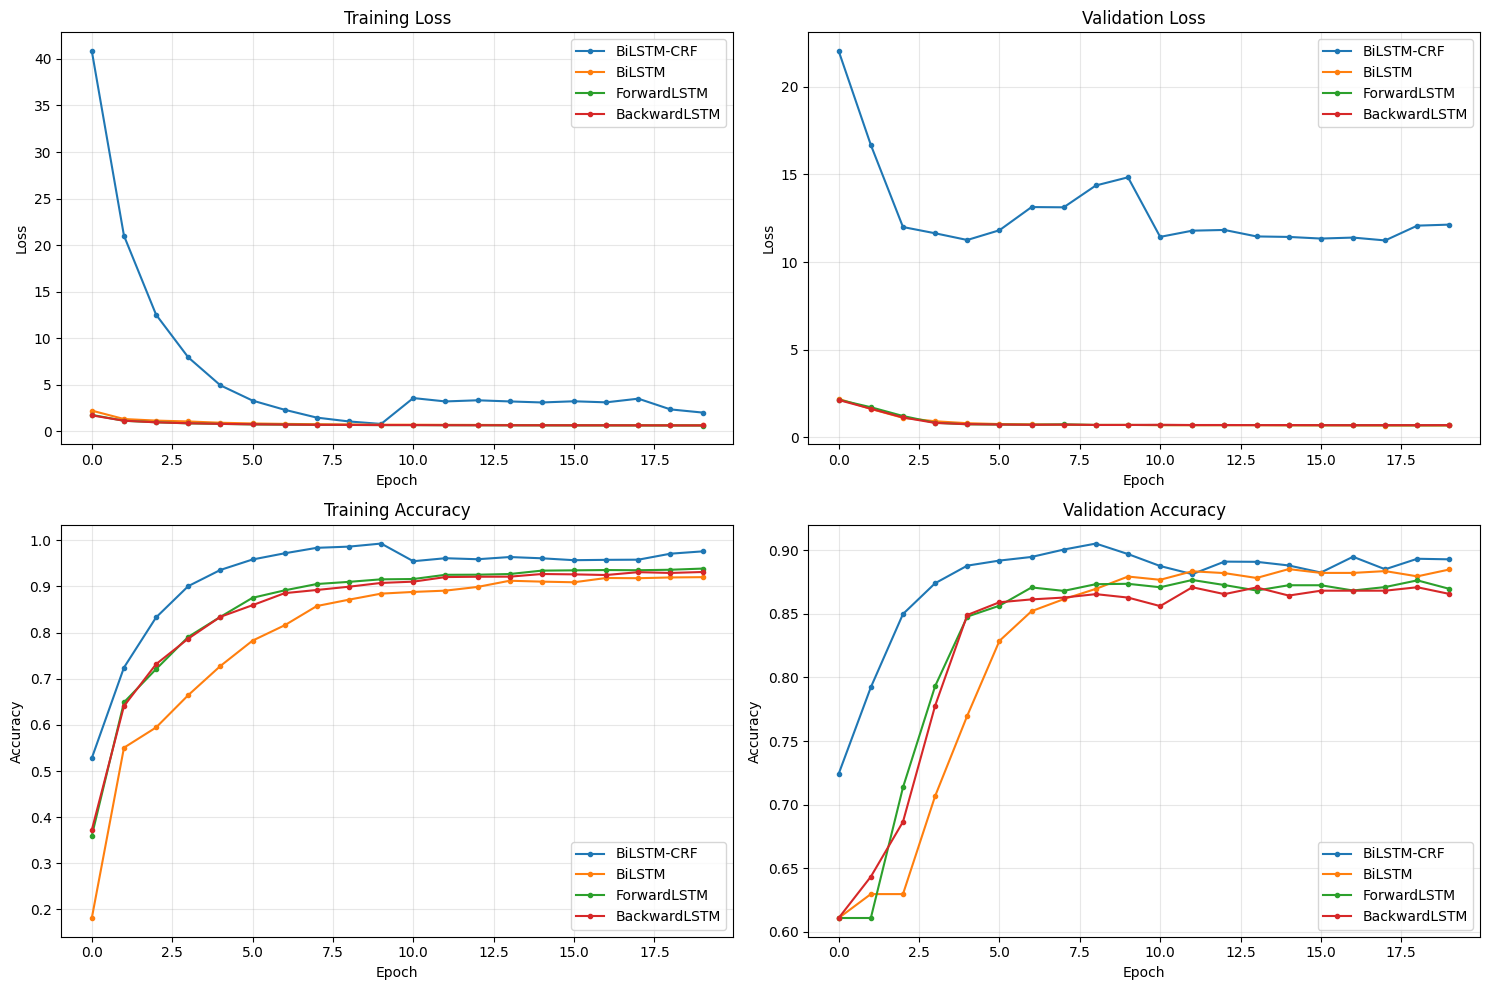

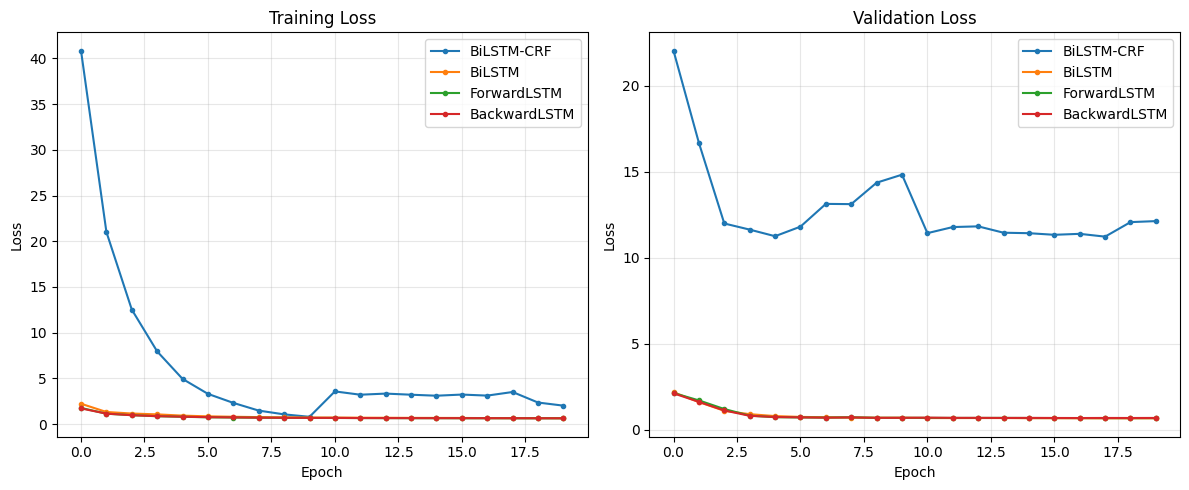

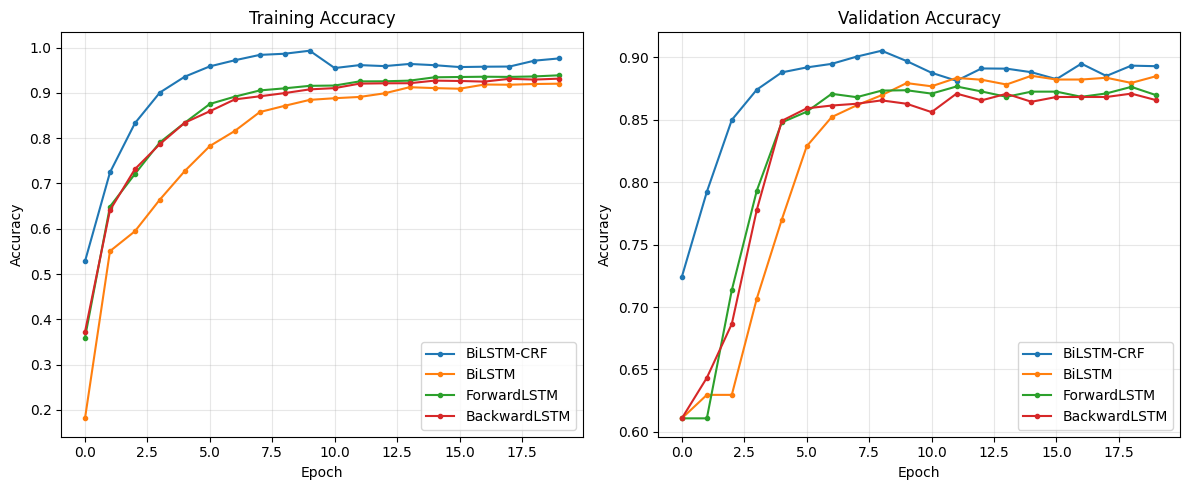

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

def compute_accuracy(pred_tags, true_tags, mask=None):
    """
    Compute accuracy considering the mask for padding and handling different input formats
    
    Args:
        pred_tags: torch.Tensor or numpy array of predictions
        true_tags: torch.Tensor or numpy array of true labels
        mask: torch.Tensor or numpy array of boolean mask (optional)
    """
    # Convert to numpy arrays
    if isinstance(pred_tags, torch.Tensor):
        pred_tags = pred_tags.cpu().detach().numpy()
    if isinstance(true_tags, torch.Tensor):
        true_tags = true_tags.cpu().detach().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    # Handle one-hot encoded true tags
    if true_tags.ndim == 3:
        true_tags = np.argmax(true_tags, axis=-1)
    
    # Ensure predictions are 2D
    if pred_tags.ndim == 3:
        pred_tags = np.argmax(pred_tags, axis=-1)
    
    # Reshape both arrays to 2D if they're not already
    if pred_tags.ndim == 1:
        pred_tags = pred_tags.reshape(-1, 1)
    if true_tags.ndim == 1:
        true_tags = true_tags.reshape(-1, 1)
    
    # Create mask if not provided
    if mask is None:
        mask = np.ones_like(true_tags, dtype=bool)
    
    # Ensure mask has same shape as predictions
    if mask.shape != pred_tags.shape:
        # Reshape mask to match predictions
        mask = mask[:pred_tags.shape[0], :pred_tags.shape[1]]
    
    # Calculate accuracy only on valid positions
    valid_positions = mask.astype(bool)
    if valid_positions.sum() > 0:
        correct = (pred_tags[valid_positions] == true_tags[valid_positions]).sum()
        total = valid_positions.sum()
        return correct / total
    return 0.0

def plot_training_history(histories):
    """
    Plot training and validation metrics
    Args:
        histories: dictionary containing training history for each model
    """
    # Standardize metric names
    metric_mapping = {
        'acc': 'accuracy',
        'accuracy': 'accuracy',
        'loss': 'loss'
    }
    
    # Create figure for all metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    try:
        # Plot training loss
        for name, history in histories.items():
            if 'train_loss' in history:
                ax1.plot(history['train_loss'], label=f'{name}', marker='.')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot validation loss
        for name, history in histories.items():
            if 'val_loss' in history:
                ax2.plot(history['val_loss'], label=f'{name}', marker='.')
        ax2.set_title('Validation Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot training accuracy
        for name, history in histories.items():
            acc_key = next((k for k in history.keys() if 'train_acc' in k or 'train_accuracy' in k), None)
            if acc_key:
                ax3.plot(history[acc_key], label=f'{name}', marker='.')
        ax3.set_title('Training Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot validation accuracy
        for name, history in histories.items():
            acc_key = next((k for k in history.keys() if 'val_acc' in k or 'val_accuracy' in k), None)
            if acc_key:
                ax4.plot(history[acc_key], label=f'{name}', marker='.')
        ax4.set_title('Validation Accuracy')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

        # Plot individual metrics for better comparison
        metrics = ['Loss', 'Accuracy']
        for metric in metrics:
            plt.figure(figsize=(12, 5))
            
            # Training plot
            plt.subplot(1, 2, 1)
            metric_key = f'train_{metric.lower()}'
            acc_key = f'train_acc' if metric.lower() == 'accuracy' else metric_key
            
            for name, history in histories.items():
                if acc_key in history:
                    plt.plot(history[acc_key], label=f'{name}', marker='.')
                elif metric_key in history:
                    plt.plot(history[metric_key], label=f'{name}', marker='.')
            
            plt.title(f'Training {metric}')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Validation plot
            plt.subplot(1, 2, 2)
            metric_key = f'val_{metric.lower()}'
            acc_key = f'val_acc' if metric.lower() == 'accuracy' else metric_key
            
            for name, history in histories.items():
                if acc_key in history:
                    plt.plot(history[acc_key], label=f'{name}', marker='.')
                elif metric_key in history:
                    plt.plot(history[metric_key], label=f'{name}', marker='.')
            
            plt.title(f'Validation {metric}')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(f'training_{metric.lower()}.png')
            plt.show()
    
    except Exception as e:
        print(f"Error during plotting: {str(e)}")
        import traceback
        traceback.print_exc()

def train_and_evaluate_models(models, train_loader, test_loader, n_words, config, device):
    histories = {name: {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []} 
                for name in models.keys()}
    
    optimizers = {name: torch.optim.AdamW(model.parameters(), 
                                       lr=config['learning_rate'], 
                                       weight_decay=config['weight_decay'])
                 for name, model in models.items()}
    
    schedulers = {name: StepLR(optimizer, 
                              step_size=config['scheduler_step'], 
                              gamma=config['scheduler_gamma'])
                 for name, optimizer in optimizers.items()}
    
    best_metrics = {name: {'loss': float('inf'), 'acc': 0, 'epoch': 0} 
                   for name in models.keys()}
    
    patience_counters = {name: 0 for name in models.keys()}

    try:
        for epoch in range(config['num_epochs']):
            print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
            print("=" * 50)

            # Training phase
            for name, model in models.items():
                model.train()
                total_loss = 0
                total_acc = 0
                total_batches = 0

                progress_bar = tqdm(train_loader, 
                                desc=f'Training {name} - Epoch {epoch+1}/{config["num_epochs"]}')

                for batch_X, batch_y in progress_bar:
                    try:
                        # Move data to device
                        batch_X = batch_X.to(device)
                        batch_y = batch_y.to(device)
                        
                        # Get mask for padding
                        mask = (batch_X != n_words - 1)
                        
                        # Truncate sequences to match lengths
                        seq_len = min(batch_X.size(1), batch_y.size(1))
                        batch_X = batch_X[:, :seq_len]
                        batch_y = batch_y[:, :seq_len]
                        mask = mask[:, :seq_len]
                        
                        # Forward pass
                        optimizers[name].zero_grad()
                        
                        if name == 'BiLSTM-CRF':
                            loss = model(batch_X, batch_y)
                            with torch.no_grad():
                                pred_tags = model(batch_X)
                        else:
                            loss = model(batch_X, None, batch_y)
                            with torch.no_grad():
                                logits = model(batch_X)
                                pred_tags = torch.argmax(logits, dim=-1)
                        
                        # Backward pass
                        loss.backward()
                        
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                                   max_norm=config['clip_grad_norm'])
                        
                        optimizers[name].step()
                        
                        # Calculate accuracy
                        accuracy = compute_accuracy(pred_tags, batch_y, mask)
                        
                        total_loss += loss.item()
                        total_acc += accuracy
                        total_batches += 1
                        
                        # Update progress bar
                        progress_bar.set_postfix({
                            'loss': f'{total_loss/total_batches:.4f}',
                            'acc': f'{total_acc/total_batches:.4f}'
                        })
                        
                    except Exception as e:
                        print(f"\nError in batch training for {name}: {str(e)}")
                        continue

                if total_batches > 0:
                    # Calculate average training metrics
                    avg_train_loss = total_loss / total_batches
                    avg_train_acc = total_acc / total_batches
                    
                    # Validation phase
                    model.eval()
                    val_loss = 0
                    val_acc = 0
                    val_batches = 0
                    
                    print(f"\nRunning validation for {name}...")
                    val_progress_bar = tqdm(test_loader, desc='Validation')
                    
                    with torch.no_grad():
                        for batch_X, batch_y in val_progress_bar:
                            try:
                                batch_X = batch_X.to(device)
                                batch_y = batch_y.to(device)
                                
                                # Get mask for padding
                                mask = (batch_X != n_words - 1)
                                
                                # Match sequence lengths
                                seq_len = min(batch_X.size(1), batch_y.size(1))
                                batch_X = batch_X[:, :seq_len]
                                batch_y = batch_y[:, :seq_len]
                                mask = mask[:, :seq_len]
                                
                                if name == 'BiLSTM-CRF':
                                    loss = model(batch_X, batch_y)
                                    pred_tags = model(batch_X)
                                else:
                                    loss = model(batch_X, None, batch_y)
                                    logits = model(batch_X)
                                    pred_tags = torch.argmax(logits, dim=-1)
                                
                                accuracy = compute_accuracy(pred_tags, batch_y, mask)
                                
                                val_loss += loss.item()
                                val_acc += accuracy
                                val_batches += 1
                                
                                # Update progress bar
                                val_progress_bar.set_postfix({
                                    'loss': f'{val_loss/val_batches:.4f}',
                                    'acc': f'{val_acc/val_batches:.4f}'
                                })
                                
                            except Exception as e:
                                print(f"\nError in validation batch for {name}: {str(e)}")
                                continue
                    
                    if val_batches > 0:
                        avg_val_loss = val_loss / val_batches
                        avg_val_acc = val_acc / val_batches
                        
                        # Save metrics
                        histories[name]['train_loss'].append(avg_train_loss)
                        histories[name]['val_loss'].append(avg_val_loss)
                        histories[name]['train_acc'].append(avg_train_acc)
                        histories[name]['val_acc'].append(avg_val_acc)
                        
                        # Update learning rate scheduler
                        schedulers[name].step()
                        
                        print(f"\n{name} Results:")
                        print(f"Training Loss: {avg_train_loss:.4f}")
                        print(f"Validation Loss: {avg_val_loss:.4f}")
                        print(f"Training Accuracy: {avg_train_acc:.4f}")
                        print(f"Validation Accuracy: {avg_val_acc:.4f}")
                        print(f"Learning Rate: {schedulers[name].get_last_lr()[0]:.6f}")
                        
                        # Early stopping check
                        if avg_val_loss < best_metrics[name]['loss']:
                            best_metrics[name]['loss'] = avg_val_loss
                            best_metrics[name]['acc'] = avg_val_acc
                            best_metrics[name]['epoch'] = epoch
                            patience_counters[name] = 0
                            
                            # Save best model
                            torch.save({
                                'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizers[name].state_dict(),
                                'loss': avg_val_loss,
                                'accuracy': avg_val_acc
                            }, f'best_model_{name.lower()}.pth')
                            print(f"Saved new best model for {name}!")
                        else:
                            patience_counters[name] += 1
                            if patience_counters[name] >= config['patience']:
                                print(f"\nEarly stopping triggered for {name}")
                                # Load best model
                                model.load_state_dict(torch.load(
                                    f'best_model_{name.lower()}.pth')['model_state_dict']
                                )

    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    
    return histories, best_metrics

def prepare_data_and_models(X_train, y_train, X_test, y_test, config):
    """
    Prepare data loaders and initialize models with proper configuration
    """
    # Convert lists to numpy arrays if needed
    if isinstance(X_train, list):
        X_train = np.array(X_train)
    if isinstance(y_train, list):
        y_train = np.array(y_train)
    if isinstance(X_test, list):
        X_test = np.array(X_test)
    if isinstance(y_test, list):
        y_test = np.array(y_test)
    
    # Print original shapes for debugging
    print("Original data shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")

    # Convert data to tensors with proper shape
    X_train_tensor = torch.LongTensor(X_train)
    X_test_tensor = torch.LongTensor(X_test)
    
    # Handle y data properly - keep original dimensionality for CRF
    if len(y_train.shape) == 3:  # if one-hot encoded
        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)
    else:
        y_train_tensor = torch.LongTensor(y_train)
        y_test_tensor = torch.LongTensor(y_test)

    # Print tensor shapes for verification
    print("\nTensor shapes:")
    print(f"X_train_tensor: {X_train_tensor.shape}")
    print(f"y_train_tensor: {y_train_tensor.shape}")
    print(f"X_test_tensor: {X_test_tensor.shape}")
    print(f"y_test_tensor: {y_test_tensor.shape}")
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True,
        drop_last=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'],
        drop_last=True
    )

    # Initialize models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    models = {
        'BiLSTM-CRF': ImprovedBiLSTM_CRF(
            vocab_size=n_words,
            tagset_size=n_tags,
            embedding_dim=config['embedding_dim'],
            hidden_dim=config['hidden_dim'],
            dropout=config['dropout']
        ),
        'BiLSTM': BiLSTM(
            vocab_size=n_words,
            tagset_size=n_tags,
            embedding_dim=config['embedding_dim'],
            hidden_dim=config['hidden_dim'],
            num_layers=config['num_layers'],
            dropout=config['dropout']
        ),
        'ForwardLSTM': ForwardLSTM(
            vocab_size=n_words,
            tagset_size=n_tags,
            embedding_dim=config['embedding_dim'],
            hidden_dim=config['hidden_dim'],
            num_layers=config['num_layers'],
            dropout=config['dropout']
        ),
        'BackwardLSTM': BackwardLSTM(
            vocab_size=n_words,
            tagset_size=n_tags,
            embedding_dim=config['embedding_dim'],
            hidden_dim=config['hidden_dim'],
            num_layers=config['num_layers'],
            dropout=config['dropout']
        )
    }

    # Move models to device
    models = {name: model.to(device) for name, model in models.items()}

    return train_loader, test_loader, models, device


config = {
    'embedding_dim': 200,
    'hidden_dim': 256,
    'num_layers': 2,
    'dropout': 0.3,
    'batch_size': 16,
    'num_epochs': 20,
    'learning_rate': 0.001,
    'weight_decay': 0.01,
    'scheduler_step': 3,
    'scheduler_gamma': 0.8,
    'patience': 5,
    'clip_grad_norm': 1.0,
    'max_seq_len': 49
}

def run_training():
    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Prepare data and models
    train_loader, test_loader, models, device = prepare_data_and_models(
        X_train, y_train, X_test, y_test, config
    )

    print(f"Using device: {device}")
    print("\nModel Architectures:")
    for name, model in models.items():
        print(f"\n{name}:")
        print("=" * 50)
        print(model)
        print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
        
        # Initialize model weights if not CRF
        if name != 'BiLSTM-CRF':
            for p in model.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)

    # Train models
    print("\nStarting training...")
    histories, best_metrics = train_and_evaluate_models(
        models, train_loader, test_loader, n_words, config, device 
    )

    # Plot and save results
    plot_training_history(histories)
    save_results(histories, best_metrics)

    return histories, best_metrics

def save_results(histories, best_metrics):
    """
    Save training results and metrics
    """
    try:
        # Save histories to file
        for name, history in histories.items():
            with open(f'history_{name.lower()}.txt', 'w') as f:
                for key, values in history.items():
                    f.write(f"{key}:\n")
                    for v in values:
                        f.write(f"{v:.6f}\n")
                    f.write("\n")

        # Save best metrics to file
        with open('best_metrics.txt', 'w') as f:
            f.write("Final Results:\n")
            f.write("=" * 50 + "\n")
            for name, metrics in best_metrics.items():
                f.write(f"\n{name}:\n")
                f.write(f"Best Validation Loss: {metrics['loss']:.4f}\n")
                f.write(f"Best Validation Accuracy: {metrics['acc']:.4f}\n")
                f.write(f"Best Epoch: {metrics['epoch'] + 1}\n")
    except Exception as e:
        print(f"Error saving results: {str(e)}")
        import traceback
        traceback.print_exc()
        
def preprocess_data(X, y):
    """
    Preprocess data to ensure correct format and shape
    """
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Check if y needs to be one-hot encoded
    if len(y.shape) == 2:  # If not already one-hot encoded
        y_one_hot = np.zeros((y.shape[0], y.shape[1], n_tags))
        for i in range(y.shape[0]):
            for j in range(y.shape[1]):
                if y[i,j] < n_tags:
                    y_one_hot[i,j,y[i,j]] = 1
        y = y_one_hot
    
    return X, y

# Preprocess the data
X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

print("After preprocessing:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

histories, best_metrics = run_training()

C:\Users\megar\AppData\Local\Temp\ipykernel_17152\1016159098.py:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devi

Starting complete evaluation...

Validating input data...
X shape: (39, 42)
y shape: (39, 49, 13)
Input tensor shape: torch.Size([39, 42])
Target tensor shape: torch.Size([39, 49])
Created DataLoader with 5 batches
Using device: cpu

Evaluating BiLSTM-CRF...


Testing BiLSTM-CRF: 100%|██████████| 5/5 [00:00<00:00, 40.24it/s]
C:\Users\megar\AppData\Local\Temp\ipykernel_17152\1016159098.py:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea


Results for BiLSTM-CRF:
Classification Report:
                  precision    recall  f1-score   support

         B-Brand       0.79      0.85      0.81        39
    B-OnlineShop       1.00      0.97      0.99        40
         B-Price       0.90      0.93      0.91        40
       B-Product       0.80      0.81      0.80        58
         B-Promo       0.93      0.82      0.87        33
B-Specifications       0.57      0.51      0.54        39
      B-Warranty       1.00      1.00      1.00         5
         I-Brand       1.00      0.50      0.67         4
       I-Product       0.78      0.67      0.72        21
         I-Promo       0.93      0.85      0.89        33
I-Specifications       0.73      0.34      0.47        32
      I-Warranty       1.00      1.00      1.00        10
               O       0.91      0.96      0.93       582

        accuracy                           0.89       936
       macro avg       0.87      0.78      0.82       936
    weighted avg      

Testing BiLSTM: 100%|██████████| 5/5 [00:00<00:00, 64.46it/s]
c:\Users\megar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\megar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Results for BiLSTM:
Classification Report:
                  precision    recall  f1-score   support

         B-Brand       0.00      0.00      0.00        39
    B-OnlineShop       1.00      0.97      0.99        40
         B-Price       0.95      0.93      0.94        40
       B-Product       0.84      0.79      0.81        58
         B-Promo       0.94      0.88      0.91        33
B-Specifications       0.76      0.56      0.65        39
      B-Warranty       1.00      1.00      1.00         5
         I-Brand       1.00      0.50      0.67         4
       I-Product       0.71      0.71      0.71        21
         I-Promo       0.97      0.85      0.90        33
I-Specifications       0.86      0.56      0.68        32
      I-Warranty       1.00      1.00      1.00        10
               O       0.88      0.99      0.93       582

        accuracy                           0.88       936
       macro avg       0.84      0.75      0.78       936
    weighted avg       0.8

c:\Users\megar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\megar\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\megar\AppData\Local\Temp\ipykernel_17152\1016159098.py:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickli


Results for ForwardLSTM:
Classification Report:
                  precision    recall  f1-score   support

         B-Brand       0.00      0.00      0.00        39
    B-OnlineShop       1.00      1.00      1.00        40
         B-Price       1.00      0.90      0.95        40
       B-Product       0.84      0.79      0.81        58
         B-Promo       0.94      0.88      0.91        33
B-Specifications       0.72      0.54      0.62        39
      B-Warranty       1.00      1.00      1.00         5
         I-Brand       0.40      0.50      0.44         4
       I-Product       0.69      0.86      0.77        21
         I-Promo       0.90      0.85      0.88        33
I-Specifications       0.68      0.53      0.60        32
      I-Warranty       1.00      1.00      1.00        10
               O       0.88      0.97      0.92       582

        accuracy                           0.87       936
       macro avg       0.77      0.76      0.76       936
    weighted avg     

Testing BackwardLSTM: 100%|██████████| 5/5 [00:00<00:00, 92.62it/s]
c:\Users\megar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\megar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\megar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d


Results for BackwardLSTM:
Classification Report:
                  precision    recall  f1-score   support

         B-Brand       0.00      0.00      0.00        39
    B-OnlineShop       1.00      1.00      1.00        40
         B-Price       0.97      0.85      0.91        40
       B-Product       0.87      0.81      0.84        58
         B-Promo       0.85      0.88      0.87        33
B-Specifications       0.60      0.62      0.61        39
      B-Warranty       1.00      1.00      1.00         5
         I-Brand       1.00      0.50      0.67         4
       I-Product       0.70      0.76      0.73        21
         I-Promo       0.96      0.82      0.89        33
I-Specifications       0.74      0.44      0.55        32
      I-Warranty       1.00      1.00      1.00        10
               O       0.88      0.97      0.92       582

        accuracy                           0.87       936
       macro avg       0.81      0.74      0.77       936
    weighted avg    

<Figure size 1500x1000 with 0 Axes>

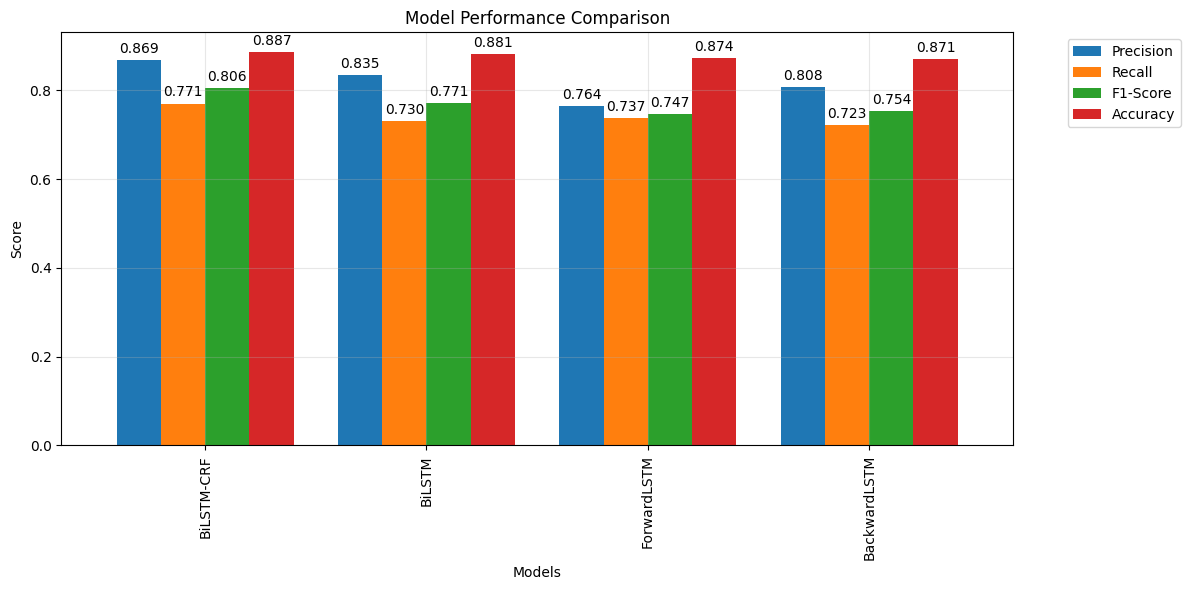


Detailed Model Comparison:
              Precision  Recall  F1-Score  Accuracy
BiLSTM-CRF       0.8693  0.7705    0.8060    0.8868
BiLSTM           0.8347  0.7301    0.7712    0.8814
ForwardLSTM      0.7643  0.7373    0.7473    0.8739
BackwardLSTM     0.8076  0.7227    0.7540    0.8707

Per-Class Performance:

BiLSTM-CRF:
----------------------------------------
                  precision    recall  f1-score   support

         B-Brand       0.79      0.85      0.81        39
    B-OnlineShop       1.00      0.97      0.99        40
         B-Price       0.90      0.93      0.91        40
       B-Product       0.80      0.81      0.80        58
         B-Promo       0.93      0.82      0.87        33
B-Specifications       0.57      0.51      0.54        39
      B-Warranty       1.00      1.00      1.00         5
         I-Brand       1.00      0.50      0.67         4
       I-Product       0.78      0.67      0.72        21
         I-Promo       0.93      0.85      0.89      

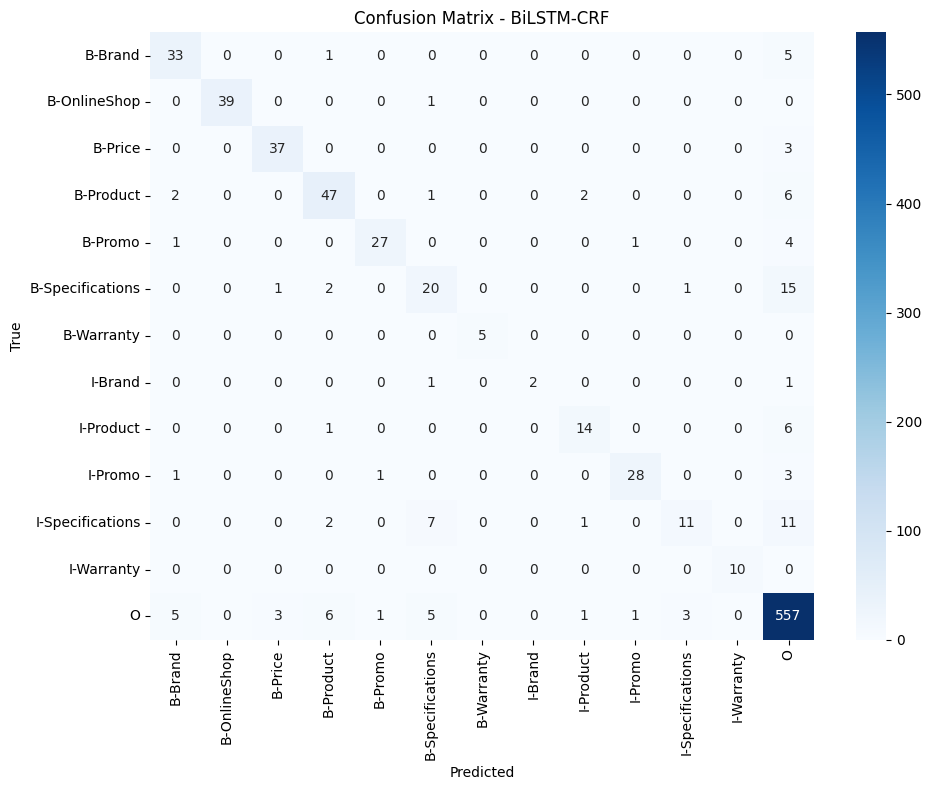


BiLSTM:
----------------------------------------
                  precision    recall  f1-score   support

         B-Brand       0.00      0.00      0.00        39
    B-OnlineShop       1.00      0.97      0.99        40
         B-Price       0.95      0.93      0.94        40
       B-Product       0.84      0.79      0.81        58
         B-Promo       0.94      0.88      0.91        33
B-Specifications       0.76      0.56      0.65        39
      B-Warranty       1.00      1.00      1.00         5
         I-Brand       1.00      0.50      0.67         4
       I-Product       0.71      0.71      0.71        21
         I-Promo       0.97      0.85      0.90        33
I-Specifications       0.86      0.56      0.68        32
      I-Warranty       1.00      1.00      1.00        10
               O       0.88      0.99      0.93       582

        accuracy                           0.88       936
       macro avg       0.84      0.75      0.78       936
    weighted avg    

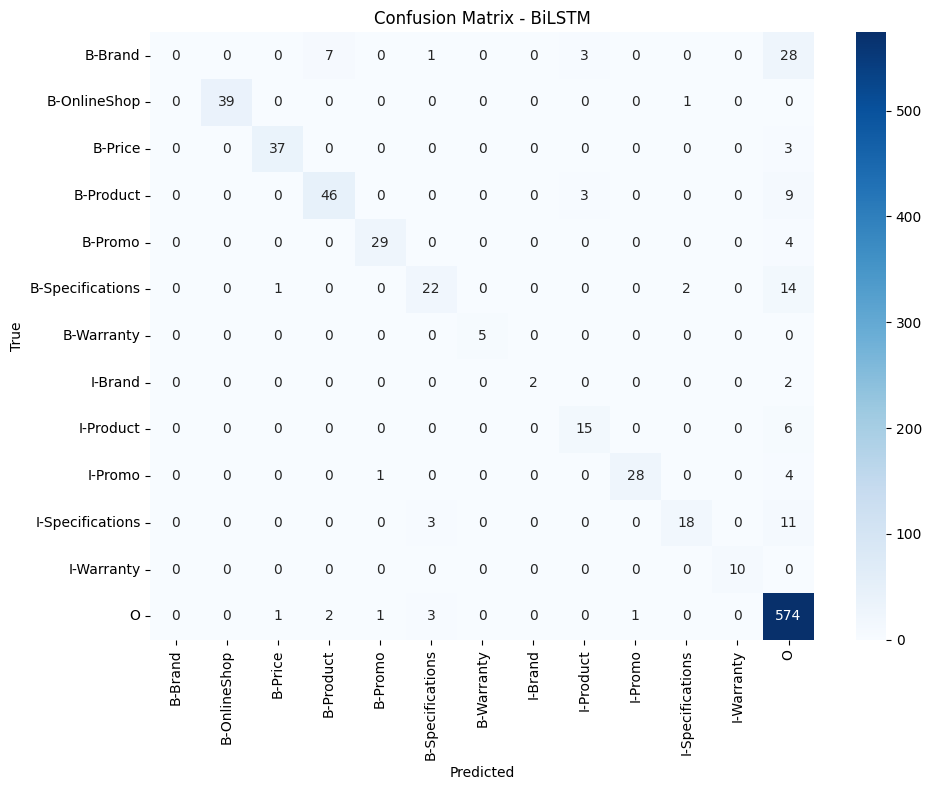


ForwardLSTM:
----------------------------------------
                  precision    recall  f1-score   support

         B-Brand       0.00      0.00      0.00        39
    B-OnlineShop       1.00      1.00      1.00        40
         B-Price       1.00      0.90      0.95        40
       B-Product       0.84      0.79      0.81        58
         B-Promo       0.94      0.88      0.91        33
B-Specifications       0.72      0.54      0.62        39
      B-Warranty       1.00      1.00      1.00         5
         I-Brand       0.40      0.50      0.44         4
       I-Product       0.69      0.86      0.77        21
         I-Promo       0.90      0.85      0.88        33
I-Specifications       0.68      0.53      0.60        32
      I-Warranty       1.00      1.00      1.00        10
               O       0.88      0.97      0.92       582

        accuracy                           0.87       936
       macro avg       0.77      0.76      0.76       936
    weighted av

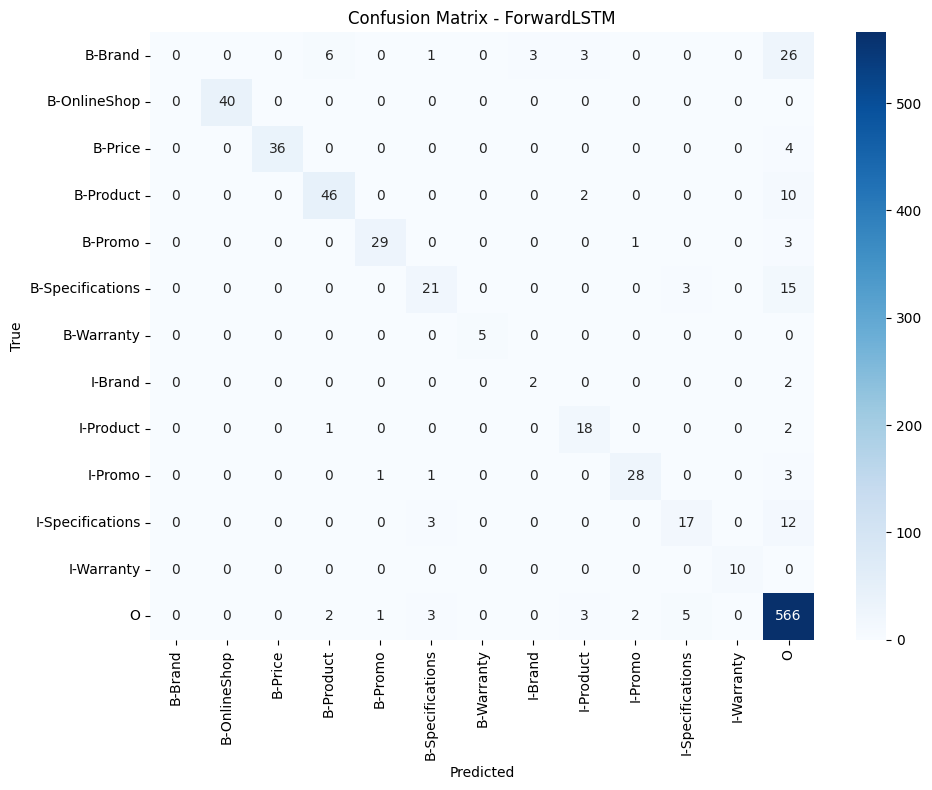


BackwardLSTM:
----------------------------------------
                  precision    recall  f1-score   support

         B-Brand       0.00      0.00      0.00        39
    B-OnlineShop       1.00      1.00      1.00        40
         B-Price       0.97      0.85      0.91        40
       B-Product       0.87      0.81      0.84        58
         B-Promo       0.85      0.88      0.87        33
B-Specifications       0.60      0.62      0.61        39
      B-Warranty       1.00      1.00      1.00         5
         I-Brand       1.00      0.50      0.67         4
       I-Product       0.70      0.76      0.73        21
         I-Promo       0.96      0.82      0.89        33
I-Specifications       0.74      0.44      0.55        32
      I-Warranty       1.00      1.00      1.00        10
               O       0.88      0.97      0.92       582

        accuracy                           0.87       936
       macro avg       0.81      0.74      0.77       936
    weighted a

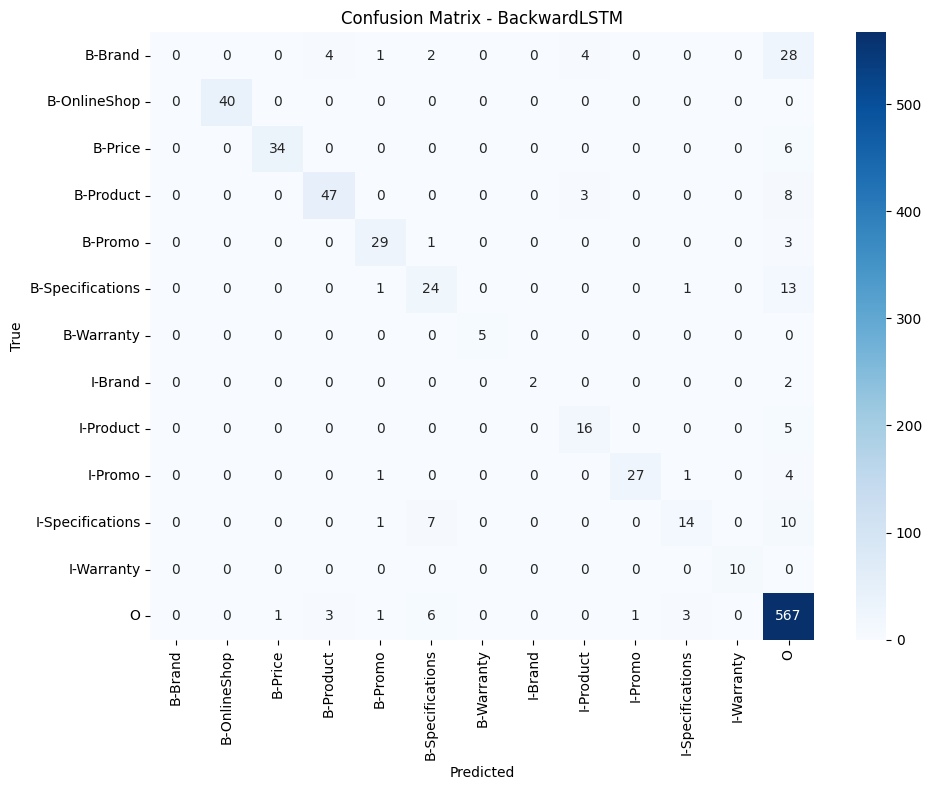

In [313]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import (
    precision_recall_fscore_support, 
    classification_report,
    confusion_matrix
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

def validate_data(X_test, y_test):
    """
    Validate input data before evaluation
    """
    print("\nValidating input data...")
    
    # Check if data exists
    if X_test is None or y_test is None:
        raise ValueError("Input data cannot be None")
        
    # Convert lists to numpy arrays if needed
    X = np.array(X_test) if isinstance(X_test, list) else X_test
    y = np.array(y_test) if isinstance(y_test, list) else y_test
    
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y

def prepare_evaluation_data(X_test, y_test, batch_size=8):
    """
    Prepare data loader for evaluation
    """
    try:
        # Validate input data
        X, y = validate_data(X_test, y_test)
        
        # Convert to tensors
        X_tensor = torch.LongTensor(X)
        
        # Handle one-hot encoded targets
        if len(y.shape) == 3:
            y_tensor = torch.LongTensor(np.argmax(y, axis=2))
        else:
            y_tensor = torch.LongTensor(y)
            
        print(f"Input tensor shape: {X_tensor.shape}")
        print(f"Target tensor shape: {y_tensor.shape}")
        
        # Create dataset and loader
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False
        )
        
        print(f"Created DataLoader with {len(loader)} batches")
        return loader
        
    except Exception as e:
        print(f"Error preparing data: {str(e)}")
        traceback.print_exc()
        return None

def plot_model_comparisons(results):
    """
    Plot comparison of metrics across models
    """
    # Extract metrics for each model
    model_metrics = {
        name: {
            'Precision': metrics['macro_metrics']['precision'],
            'Recall': metrics['macro_metrics']['recall'],
            'F1-Score': metrics['macro_metrics']['f1'],
            'Accuracy': metrics['accuracy']
        }
        for name, metrics in results.items()
    }
    
    # Convert to DataFrame for easier plotting
    metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index')
    
    # Create comparison plots
    plt.figure(figsize=(15, 10))
    
    # Bar plot
    ax = metrics_df.plot(kind='bar', width=0.8, figsize=(12, 6))
    plt.title('Model Performance Comparison')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()
    
    # Print detailed metrics table
    print("\nDetailed Model Comparison:")
    print("=" * 80)
    comparison_table = metrics_df.round(4)
    print(comparison_table.to_string())
    
    # Print per-class metrics for each model
    print("\nPer-Class Performance:")
    print("=" * 80)
    for name, metrics in results.items():
        print(f"\n{name}:")
        print("-" * 40)
        print(metrics['classification_report'])
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(metrics['confusion_matrix'], 
                   annot=True, 
                   fmt='d',
                   cmap='Blues',
                   xticklabels=metrics['confusion_matrix'].columns,
                   yticklabels=metrics['confusion_matrix'].index)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{name.lower()}.png')
        plt.show()

def calculate_metrics(true_tags, pred_tags):
    """
    Calculate detailed metrics for NER evaluation
    """
    # Get unique labels (excluding 'O')
    labels = sorted(list(set(true_tags) - {'O'}))
    
    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        true_tags, 
        pred_tags,
        labels=labels,
        zero_division=0
    )
    
    # Calculate macro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        true_tags, 
        pred_tags,
        average='macro',
        labels=labels,
        zero_division=0
    )
    
    # Calculate accuracy
    accuracy = np.mean([p == t for p, t in zip(pred_tags, true_tags)])
    
    # Get classification report
    report = classification_report(true_tags, pred_tags)
    
    # Create confusion matrix
    all_labels = sorted(list(set(true_tags)))
    conf_matrix = confusion_matrix(true_tags, pred_tags, labels=all_labels)
    
    # Convert to DataFrame
    conf_df = pd.DataFrame(
        conf_matrix,
        index=all_labels,
        columns=all_labels
    )
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Label': labels,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    return {
        'metrics_df': metrics_df,
        'confusion_matrix': conf_df,
        'classification_report': report,
        'accuracy': accuracy,
        'macro_metrics': {
            'precision': macro_precision,
            'recall': macro_recall,
            'f1': macro_f1
        }
    }

def evaluate_models(test_loader, idx2tag, device='cpu'):
    """
    Evaluate all models with proper error handling and metrics calculation
    """
    model_configs = {
        'BiLSTM-CRF': {
            'path': 'best_model_bilstm-crf.pth',
            'class': ImprovedBiLSTM_CRF,
            'params': {
                'vocab_size': n_words,
                'tagset_size': n_tags,
                'embedding_dim': 200,
                'hidden_dim': 256,
                'num_layers': 2,
                'dropout': 0.5
            }
        },
        'BiLSTM': {
            'path': 'best_model_bilstm.pth',
            'class': BiLSTM,
            'params': {
                'vocab_size': n_words,
                'tagset_size': n_tags,
                'embedding_dim': 200,
                'hidden_dim': 256,
                'num_layers': 2,
                'dropout': 0.5
            }
        },
        'ForwardLSTM': {
            'path': 'best_model_forwardlstm.pth',
            'class': ForwardLSTM,
            'params': {
                'vocab_size': n_words,
                'tagset_size': n_tags,
                'embedding_dim': 200,
                'hidden_dim': 256,
                'num_layers': 2,
                'dropout': 0.5
            }
        },
        'BackwardLSTM': {
            'path': 'best_model_backwardlstm.pth',
            'class': BackwardLSTM,
            'params': {
                'vocab_size': n_words,
                'tagset_size': n_tags,
                'embedding_dim': 200,
                'hidden_dim': 256,
                'num_layers': 2,
                'dropout': 0.5
            }
        }
    }
    
    results = {}
    summary_data = []
    
    for name, config in model_configs.items():
        try:
            print(f"\nEvaluating {name}...")
            
            # Initialize model
            model = config['class'](**config['params']).to(device)
            
            # Load checkpoint
            checkpoint_path = config['path']
            if not os.path.exists(checkpoint_path):
                print(f"No checkpoint found at {checkpoint_path}")
                continue
                
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            # Evaluate model
            all_predictions = []
            all_true_tags = []
            
            with torch.no_grad():
                for batch_X, batch_y in tqdm(test_loader, desc=f"Testing {name}"):
                    try:
                        batch_X = batch_X.to(device)
                        batch_y = batch_y.to(device)
                        mask = (batch_X != n_words - 1)
                        
                        if name == 'BiLSTM-CRF':
                            predictions = model(batch_X)
                        else:
                            # For other models
                            logits = model(batch_X, None)  # Add None for char_tensor
                            # Ensure logits has shape [batch_size, seq_len, num_tags]
                            if logits.dim() == 2:
                                logits = logits.unsqueeze(-1)
                            predictions = torch.argmax(logits, dim=-1)
                        
                        # Convert predictions and true labels to tags
                        for pred_seq, true_seq, seq_mask in zip(predictions, batch_y, mask):
                            valid_len = seq_mask.sum().item()
                            
                            # Handle predictions
                            if isinstance(pred_seq, torch.Tensor):
                                pred_tags = [idx2tag[idx.item()] for idx in pred_seq[:valid_len]]
                            else:
                                pred_tags = [idx2tag[idx] for idx in pred_seq[:valid_len]]
                            
                            # Handle true labels
                            true_tags = [idx2tag[idx.item()] for idx in true_seq[:valid_len]]
                            
                            all_predictions.extend(pred_tags)
                            all_true_tags.extend(true_tags)
                            
                    except Exception as e:
                        print(f"Error processing batch: {str(e)}")
                        traceback.print_exc()
                        continue
            
            if len(all_predictions) > 0 and len(all_true_tags) > 0:
                # Calculate metrics
                metrics = calculate_metrics(all_true_tags, all_predictions)
                results[name] = metrics
                
                # Add to summary
                summary_data.append({
                    'Model': name,
                    'Macro Precision': metrics['macro_metrics']['precision'],
                    'Macro Recall': metrics['macro_metrics']['recall'],
                    'Macro F1': metrics['macro_metrics']['f1'],
                    'Accuracy': metrics['accuracy']
                })
                
                print(f"\nResults for {name}:")
                print("Classification Report:")
                print(metrics['classification_report'])
            else:
                print(f"No valid predictions for {name}")
            
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            traceback.print_exc()
            continue
    
    if results:
        # Create summary DataFrame
        summary = pd.DataFrame(summary_data)
        
        # Plot comparisons
        plot_model_comparisons(results)
        
        return results, summary
    else:
        print("No results to display.")
        return None, None

def run_complete_evaluation():
    """
    Run complete evaluation process including visualization
    """
    try:
        # Prepare data
        test_loader = prepare_evaluation_data(X_test, y_test)
        if test_loader is None:
            return None, None
            
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Run evaluation
        results, summary = evaluate_models(test_loader, idx2tag, device)
        
        # Save results
        with open('evaluation_results.txt', 'w') as f:
            f.write("Model Evaluation Results\n")
            f.write("=" * 80 + "\n\n")
            
            for name, metrics in results.items():
                f.write(f"{name}:\n")
                f.write("-" * 40 + "\n")
                f.write(metrics['classification_report'])
                f.write("\n" + "=" * 40 + "\n\n")
            
            f.write("\nModel Comparison Summary:\n")
            f.write(summary.to_string())
        
        return results, summary
        
    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    print("Starting complete evaluation...")
    results, summary = run_complete_evaluation()